# Notebook 1
==================================================================================

# Modeling Current Price using Fundamentals
A central task with which fundamental analysts concern themselves is modeling the intrinsic value of securities using fundamental financial data related to a company. Value investors, such as Warren Buffet, then compare the current trading price to their estimate of intrinsic value in order to identify securities which are currently over or under valued, and create trading strategies which assume that the market price will eventually move toward their estimate of intrinsic value. A "Margin of Safety" represents the size of the gap between market price and intrinsic value, and a larger margin of safety should indicate a safer directional bet. 

The success of this technique depends upon the quality of the analyst's method of intrinsic value estimation. Much research and numerous techniques have been developed in this pursuit. The classic approach of asset valuation comes in the form of the Capital Asset Pricing Model (CAPM), which is a (in today's world) rather rudamentary model for pricing assets based on their risk premium, taking into account the expected market return versus the risk-free-rate of return which an investor could get by simply investing into risk-free treasury bonds. This method has proven successful for value investors in the past, but the widespread use of this technique, the introduction of many more traders into the market, as well as automated trading systems, has obfuscated the way that securities can be valuated, and more modern techniques of asset price estimation have been sought after.

I will now attempt to create asset pricing models using Machine Learning, trained using the fundamental financial data for each company in the S&P 500 scraped from TD Ameritrade's website on May 8th, 2020, with the log closing price of that same day as the target variable. The predictions of the model can then be used as intrinsic value estimates, then margins of safety can be reflected in the residuals of this model, which could be used to develop a trading strategy for a 6 month period. It will then be useful to see use the actual returns of these securities since this date to see how successful this trading strategy would have been. It will be interesting to see if there is a linear relationship between margin of safety (residuals) and returns. 

The reason for modeling the prices of the assets rather than the actual returns is that all of the data needed for this technique would have been known on the day that the fundamentals data were acquired. In the second notebook, I will be training ML models using the actual returns to see what features are the most relevant in predicting actual returns, but these analyses will be done using data that were not known at the time of the scrape, and therefore will be most useful in the near-term as analysis of feature importances and possible feature engineering techniques, with some possibility of future deployability.

### Importing Libraries and Data

In [1]:
import bot_functions as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
plt.style.use('seaborn-darkgrid')

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 7

In [6]:
# First, let's get the list of tickers used in the scrape to get target variables for
sp500_tickers = pd.read_csv('sp500.csv', usecols=[1])
sp500_tickers.head()

,Symbol
0,A
1,AAL
2,AAP
3,AAPL
4,ABBV


In [7]:
sp500_tickers.tail()

,Symbol
498,YUM
499,ZBH
500,ZBRA
501,ZION
502,ZTS


In [8]:
print(len(sp500_tickers))

503


In [9]:
# Finding odd entries in tickers list, these tickers do not have data from the scrape and do not
# work with yfinance
bad_tickers = []
for ticker in sp500_tickers.Symbol:
    if '.' in ticker:
        print(ticker)
        bad_tickers.append(ticker)

BF.B
BRK.B


In [10]:
sp500_tickers = sp500_tickers[~sp500_tickers.Symbol.isin(bad_tickers)]['Symbol']
print(len(sp500_tickers))

501


Now that we have our tickers, we can set about getting pricing information with yfinance. We will only need to concern ourselves with closing prices for our purposes.

In [11]:
# Setting start and end dates. The web scrape was done on Friday, 2020-05-08, the end date to be
# used for this project is Friday, 2020-10-30
start_date = '2020-05-08'
end_date = '2020-10-30'
# yfinance likes the tickers formatted as a list
ticks = yf.Tickers(list(sp500_tickers))
sp500_close = ticks.history(start=start_date, end=end_date).Close
sp500_close.tail()

[*********************100%***********************]  501 of 501 completed

1 Failed download:
- AGN: No data found, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-26,104.629997,11.80,151.210007,114.851852,83.919998,98.370003,288.320007,109.000000,219.229996,475.200012,...,114.225449,32.564335,47.610001,18.92,89.814369,99.199997,139.509995,295.100006,32.181160,160.479996
2020-10-27,106.040001,11.23,150.410004,116.399178,82.709999,97.650002,290.510010,108.580002,220.660004,478.559998,...,123.997673,32.046825,47.540001,18.52,88.807236,97.989998,138.600006,289.279999,30.813015,162.470001
2020-10-28,101.660004,10.95,146.380005,111.008476,80.489998,95.699997,283.000000,106.419998,213.940002,456.970001,...,119.420685,30.826271,44.840000,17.23,87.102089,95.059998,133.369995,285.200012,30.337139,158.690002
2020-10-29,102.019997,11.16,146.000000,115.121384,80.669998,94.589996,254.610001,105.000000,216.440002,461.109985,...,122.551788,32.193291,44.799999,17.65,86.613480,94.940002,133.839996,291.970001,31.288893,161.190002
2020-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# AGN was not found, it appears as though it has been acquired by ABBV since the data was
# originally scraped. I will make adjustments accordingly.

In [13]:
# We can see that yfinance has still not posted closing prices for Friday, which is part of why
# yfinance is so lame. However, it is an eas-to-access market data retrieval package so I will
# just drop friday for now so we can get moving with some analysis.

In [14]:
sp500_close = sp500_close.iloc[:-1]
sp500_close.tail()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-23,106.169998,12.60,154.720001,114.841873,84.339996,99.379997,281.420013,107.790001,229.699997,488.500000,...,116.489014,33.355255,49.150002,19.73,91.330055,101.279999,142.710007,303.720001,32.914806,163.490005
2020-10-26,104.629997,11.80,151.210007,114.851852,83.919998,98.370003,288.320007,109.000000,219.229996,475.200012,...,114.225449,32.564335,47.610001,18.92,89.814369,99.199997,139.509995,295.100006,32.181160,160.479996
2020-10-27,106.040001,11.23,150.410004,116.399178,82.709999,97.650002,290.510010,108.580002,220.660004,478.559998,...,123.997673,32.046825,47.540001,18.52,88.807236,97.989998,138.600006,289.279999,30.813015,162.470001
2020-10-28,101.660004,10.95,146.380005,111.008476,80.489998,95.699997,283.000000,106.419998,213.940002,456.970001,...,119.420685,30.826271,44.840000,17.23,87.102089,95.059998,133.369995,285.200012,30.337139,158.690002
2020-10-29,102.019997,11.16,146.000000,115.121384,80.669998,94.589996,254.610001,105.000000,216.440002,461.109985,...,122.551788,32.193291,44.799999,17.65,86.613480,94.940002,133.839996,291.970001,31.288893,161.190002


In [15]:
sp500_close['AGN']

Date
2020-05-08   NaN
2020-05-11   NaN
2020-05-12   NaN
2020-05-13   NaN
2020-05-14   NaN
              ..
2020-10-23   NaN
2020-10-26   NaN
2020-10-27   NaN
2020-10-28   NaN
2020-10-29   NaN
Name: AGN, Length: 122, dtype: float64

In [16]:
sp500_close.drop(columns=['AGN'], inplace=True)

In [17]:
# Checking tickers with NaN values
for col in sp500_close:
    if sp500_close[col].isna().sum() > 0:
        print(col)

ARNC
ETFC
VIAC


In [18]:
sp500_close[['ARNC', 'ETFC', 'VIAC']]

,ARNC,ETFC,VIAC
Date,,,
2020-05-08,9.120000,40.961483,17.931803
2020-05-11,8.780000,40.732868,17.892132
2020-05-12,8.520000,39.276699,18.100410
2020-05-13,8.300000,37.790607,16.711885
2020-05-14,8.330000,38.698219,17.019344
...,...,...,...
2020-10-23,23.889999,NaN,29.280001
2020-10-26,23.440001,NaN,28.750000
2020-10-27,23.070000,NaN,28.209999


In [19]:
# Explaining the dropout of ETFC, which is ETrade Financial Corp, it appears that Morgan
# Stanley (MS) has acquired it. Since we still have a price for the date of the data scrape,
# it can still be useful for building an asset price model, but it will not be useful for 
# modeling returns.
# Need to look now for the rows with missing values for the other two
sp500_close[sp500_close['ARNC'].isna()]['ARNC']

Date
2020-10-01   NaN
2020-10-02   NaN
Name: ARNC, dtype: float64

In [20]:
# Just a couple of missing values there, that won't affect our calculations
sp500_close[sp500_close['VIAC'].isna()]['VIAC']

Date
2020-06-05   NaN
2020-06-08   NaN
2020-06-09   NaN
2020-06-10   NaN
2020-06-11   NaN
2020-06-12   NaN
2020-06-15   NaN
2020-06-16   NaN
2020-06-17   NaN
2020-06-18   NaN
2020-06-19   NaN
2020-06-22   NaN
Name: VIAC, dtype: float64

In [21]:
# Quite a few missing values there, probably through some issue with the yfinance method.
# Still, these missing values are not important for our purposes here.

In [22]:
# Get log prices, and drop ETFC which has pricing dropout
log_close = np.log(sp500_close).drop(columns=['ETFC'])
# Create a new dataframe to store our log returns
log_returns = pd.DataFrame(index=log_close.columns, columns=['log_return'])
# Populate new dataframe with log returns for each security
for col in log_close.columns:
    log_return = log_close[col].iloc[-1] - log_close[col].iloc[0]
    log_returns.loc[col, 'log_return'] = log_return
    
log_returns.head()

,log_return
A,0.250673
AAL,0.0958479
AAP,0.161577
AAPL,0.398815
ABBV,-0.0143164


In [23]:
# Looking at log_close df
log_close.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-08,4.374496,2.316488,4.822029,4.347172,4.404683,4.469251,5.231483,4.532896,5.231851,5.906751,...,4.453416,3.769967,3.700320,2.867282,4.133082,4.446337,4.799027,5.492732,3.406633,4.829415
2020-05-11,4.393878,2.312535,4.830722,4.362785,4.450542,4.497788,5.270998,4.557875,5.227546,5.917334,...,4.448684,3.760394,3.691921,2.836476,4.125594,4.448539,4.766754,5.460691,3.356230,4.836721
2020-05-12,4.376251,2.266958,4.819222,4.351291,4.479250,4.474799,5.253791,4.533963,5.216675,5.900171,...,4.424102,3.743537,3.605698,2.797027,4.068671,4.420715,4.728749,5.438948,3.307834,4.817711
2020-05-13,4.380126,2.209373,4.776055,4.339143,4.461517,4.423493,5.223594,4.516324,5.190932,5.882096,...,4.401096,3.692626,3.615386,2.702131,4.054005,4.377410,4.706315,5.407530,3.251668,4.809777
2020-05-14,4.398420,2.213754,4.791781,4.345268,4.473485,4.422066,5.216402,4.512192,5.185336,5.873216,...,4.430157,3.701411,3.629744,2.703432,4.066637,4.412227,4.715545,5.401641,3.297358,4.833869


In [24]:
log_returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 1 columns):
log_return    499 non-null object
dtypes: object(1)
memory usage: 27.8+ KB


Text(0.5, 1.0, 'Distribution of Log Returns for SP500 since May 8, 2020')

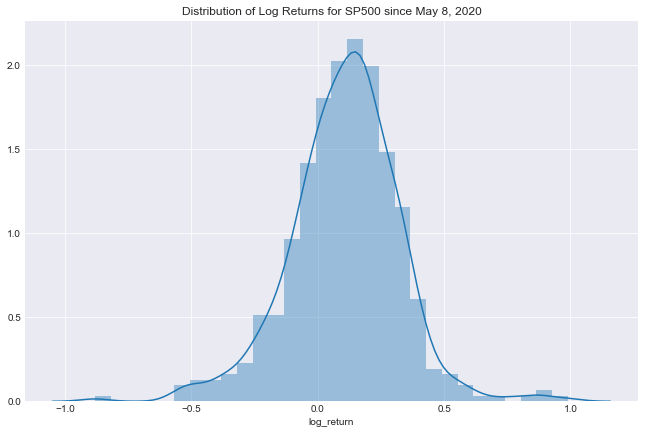

In [25]:
sns.distplot(log_returns.log_return)
plt.title('Distribution of Log Returns for SP500 since May 8, 2020')

In [26]:
# We can see above that the distribution of log returns for the past 6 months of the SP500 is
# mostly normal, and that the mean return is greater than zero. This is important to take note
# of when we try and do some classification tests later, as it may be more useful to classify
# securities based on whether they outperformed/underperformed the market, rather than whether
# they were above/below zero. This is because the analysis of such classifications would be
# more robust to varying market conditions, ie when the market as a whole moved up or down,
# since the time period in question was an overall period of growth for the market, and future
# periods of consideration may be neutral, or negative overall, and it would be better to use
# the fundamental financial data to try to find securities which would under or overperform the
# market.

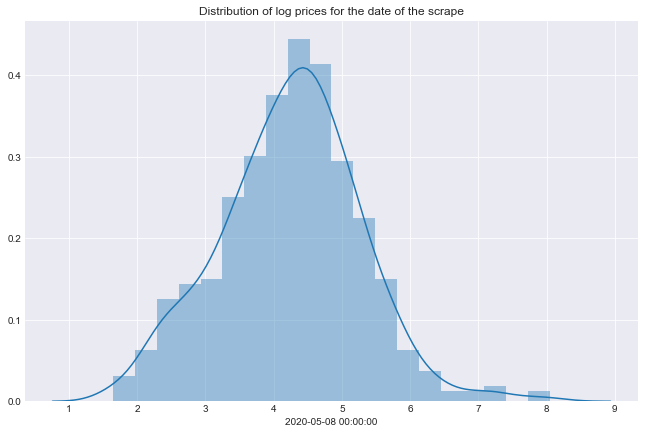

In [27]:
# First, let's look at the distribution of log prices for the date that the fundamentals data
# was scraped.
sns.distplot(log_close.iloc[0])
plt.title('Distribution of log prices for the date of the scrape');

In [28]:
# We can see that this target variable is mostly normal, which is conducive to modeling.
# Before we can make any models, we need to get our fundamentals data imported. There is a 
# function in the bot_functions file to help us do just that.
df = bf.build_big_df(sp500_tickers, 'data/sp500_close_05-08-2020')
df.head()

,% Above Low,% Below High,% Held by Institutions,52-Wk Range,5yr Avg Return,5yr High,5yr Low,Annual Dividend $,Annual Dividend %,Annual Dividend Yield,...,marketEdge,marketEdge opinion,marketEdge opinion since,marketEdge since,newConstructs,newConstructs since,researchTeam,researchTeam since,theStreet,theStreet since
A,NaN,0.1206,0.8499,['61.13 - 90.64'],0.127567,90.64,33.12,0.72,0.0092,0.0092,...,1.0,neutralfromavoid,2020-05-01,2020-05-01,3.0,2020-05-08,reduce,2020-05-01,buy,2016-03-28
AAL,0.1155,NaN,0.8162,['9.09 - 34.99'],-0.171550,59.08,9.09,NaN,NaN,NaN,...,2.0,neutralfromavoid,2020-05-01,2020-05-01,4.0,2020-05-08,reduce,2020-05-01,sell,2020-05-01
AAP,NaN,0.2717,1.0080,['71.33 - 171.43'],0.019850,201.24,71.33,1.00,0.0084,0.0084,...,1.0,neutralfromavoid,2020-05-01,2020-05-01,1.0,2020-05-08,reduce,2020-05-01,hold,2020-03-17
AAPL,NaN,0.0540,0.5986,['170.27 - 327.85'],0.214367,327.85,89.47,3.28,0.0108,0.0108,...,3.0,neutralfromavoid,2020-05-01,2020-05-01,3.0,2020-05-08,hold,2020-04-20,buy,2009-04-13
ABBV,NaN,0.1420,0.7329,['62.55 - 97.86'],0.064350,125.86,45.45,4.72,0.0560,0.0560,...,-1.0,neutralfromlong,2020-05-01,2020-05-01,1.0,2020-05-08,hold,2018-09-19,hold,2019-08-27


## Data Exploration

In [29]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 106 columns):
% Above Low                                          274 non-null float64
% Below High                                         227 non-null float64
% Held by Institutions                               495 non-null float64
52-Wk Range                                          501 non-null object
5yr Avg Return                                       501 non-null float64
5yr High                                             501 non-null float64
5yr Low                                              501 non-null float64
Annual Dividend $                                    394 non-null float64
Annual Dividend %                                    394 non-null float64
Annual Dividend Yield                                389 non-null float64
Ask                                                  494 non-null float64
Ask Size                                             492 non-null float64
Ask close   

In [30]:
# Our raw df of the data has some columns with a lot of missing data, and some columns which
# don't qualify as fundamental data, or aren't useful.
# We will not want to include any columns that are directly related to the price of the security,
# since it is the price that we are trying to model, and these columns will be cheating.
# Our goal here is to use strictly fundamental data to try and predict the trading price of
# the security, in order to find securities which are under or over valued according to this 
# model. I will make a list by hand of columns which should not be used for this.
to_drop = ['% Above Low', # Price related
           '% Below High', # Price related
           '52-Wk Range', # Price related
           '5yr High', # Price related
           '5yr Low', # Price related
           'Annual Dividend $', # Leave this out because % is more generalized
           'Ask', # Price related
           'Ask Size', # Not fundamental
           'Ask close', # Price related
           'B/A Ratio', # Not fundamental
           'B/A Size', # Not fundamental
           'Bid', # Price related
           'Bid Size', # Not fundamental
           'Bid close', # Price related
           'Change Since Close', # Price related
           'Closing Price', # Price related
           'Day Change $', # Price related
           'Day Change %', # Price related
           'Day High', # Price related
           'Day Low', # Price related
           'Dividend Pay Date', # Datetime
           'Ex-dividend', # Price related
           'Ex-dividend Date', # Datetime
           'Last (size)', # Not fundamental
           'Last (time)', # Datetime
           'Last Trade', # Price related
           'Next Earnings Announcement', # Datetime
           'Prev Close', # Price related
           'Price', # Price related
           "Today's Open", # Price related
           'Volume', # Not fundamental
           'Volume Past Day', # Not fundamental
           'cfra since', # Datetime
           'creditSuisse since', # Datetime
           'ford since', # Datetime
           'marketEdge opinion since', # Datetime
           'marketEdge since', # Datetime
           'newConstructs since', # Datetime
           'researchTeam since', # Datetime
           'theStreet since' # Datetime
          ]

X = df.drop(columns=to_drop)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 66 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
Annual Dividend %                                    394 non-null float64
Annual Dividend Yield                                389 non-null float64
Beta                                                 488 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Days to Cover                                        495 non-null float64
Dividend Change %                                    405 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      490 non-null float64
EPS Growth (MRQ)                                     487 non-null float64
EPS Growth (

In [31]:
# Comparing dividend related columns
X[['Annual Dividend %', 'Annual Dividend Yield']]

,Annual Dividend %,Annual Dividend Yield
A,0.0092,0.0092
AAL,NaN,NaN
AAP,0.0084,0.0084
AAPL,0.0108,0.0108
ABBV,0.0560,0.0560
...,...,...
YUM,0.0222,0.0218
ZBH,0.0080,0.0079
ZBRA,NaN,NaN
ZION,0.0460,0.0443


In [32]:
# We can see that these two columns are mostly the same, so the one with less missing values 
# should be dropped.
X = X.drop(columns='Annual Dividend Yield')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 65 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
Annual Dividend %                                    394 non-null float64
Beta                                                 488 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Days to Cover                                        495 non-null float64
Dividend Change %                                    405 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      490 non-null float64
EPS Growth (MRQ)                                     487 non-null float64
EPS Growth (TTM)                                     489 non-null float64
EPS Growth 5

In [33]:
# We still have a somewhat disappointing number of missing values to deal with. To get a sense
# of how they are distributed among the securites, let's see what we have left over if we 
# drop them all.
X.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, AAP to ZTS
Data columns (total 65 columns):
% Held by Institutions                               77 non-null float64
5yr Avg Return                                       77 non-null float64
Annual Dividend %                                    77 non-null float64
Beta                                                 77 non-null float64
Change in Debt/Total Capital Quarter over Quarter    77 non-null float64
Days to Cover                                        77 non-null float64
Dividend Change %                                    77 non-null float64
Dividend Growth 5yr                                  77 non-null float64
Dividend Growth Rate, 3 Years                        77 non-null float64
EPS (TTM, GAAP)                                      77 non-null float64
EPS Growth (MRQ)                                     77 non-null float64
EPS Growth (TTM)                                     77 non-null float64
EPS Growth 5yr         

In [34]:
# This is not very good news. There are only 77 securities for which we have data in all
# columns. We must address this issue

In [35]:
import missingno as msno

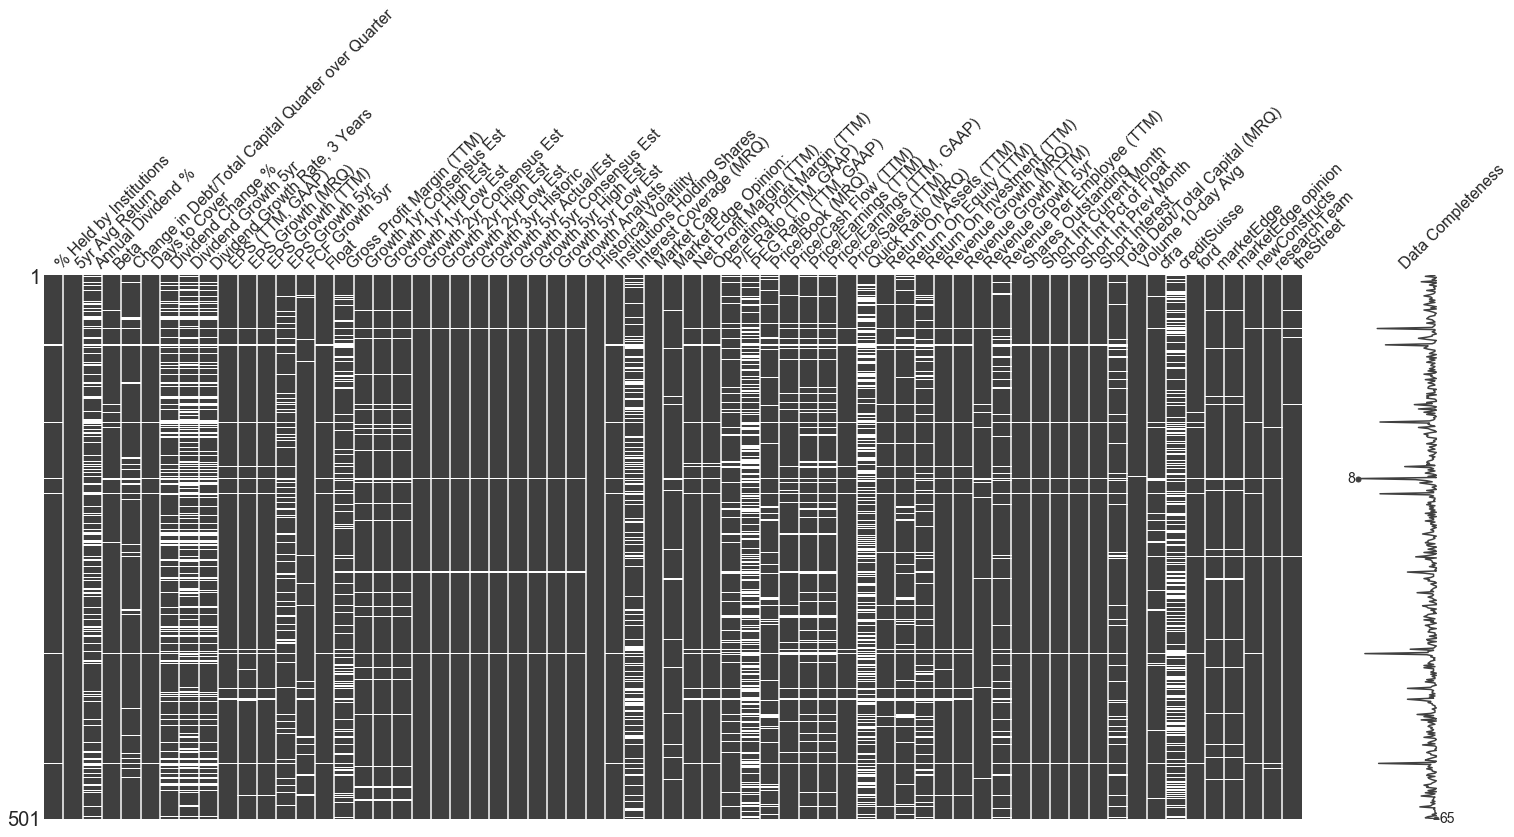

In [36]:
# A good way to investigate data sparsity is missingno
msno.matrix(X, labels=True)

In [37]:
# My first step is going to be to remove all analyst rating columns, like cfra and ford
# These are not really fundamentals information, though more investigation into them might be
# interesting to do some other time, to evaluate the quality of the ratings in terms of returns
# for certain investment horizons.
analysts = ['cfra', 
            'creditSuisse', 
            'ford', 
            'marketEdge', 
            'Market Edge Opinion:', 
            'marketEdge opinion',
            'newConstructs',
            'researchTeam',
            'theStreet'
           ]
X = X.drop(columns=analysts)

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 56 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
Annual Dividend %                                    394 non-null float64
Beta                                                 488 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Days to Cover                                        495 non-null float64
Dividend Change %                                    405 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      490 non-null float64
EPS Growth (MRQ)                                     487 non-null float64
EPS Growth (TTM)                                     489 non-null float64
EPS Growth 5

In [39]:
# Some more columns to address are dividend related.
# We can see that the Dividend %, which represents change in dividend amount over a 12 month
# period, has the least missing values, with 3 yr growth rate next, and with 5 yr growth rate
# having the most missing values. This pattern is likely resulting from the fact that some of 
# these companies don't have dividend data going back as far as others, either because they are
# a new company or because the ticker has changed in some way.
# Additionally, not all companies pay dividends to their stock holders. This is a category in
# and of itself, so it may be most useful to turn all dividend related columns into binned
# categorical variables, since the missing data actually contains information about the company,
# as well as the fact that the relationships between these columns may also provide insight.

# The same can be seen with EPS related info, and historical change of EPS.
# Some companies do not actually earn, and are currently operating at a loss, this would
# make them have no data, but since this is a useful category, these columns should be binned
# in the same way as the Dividend related columns.

# Gross Profit Margin may also be missing values because some companies are not reporting
# profits, we will bin this as well.

# The Growth related columns seen grouped together above all have to deal with what analysists
# have predicted vs what the actual growth rates were. It appears that only the 1yr column
# is missing a significant number of values, which is strange, so I may either bin this or drop
# it, since the 2yr column can be somewhat of a substitute. The only drawback to the latter is
# that analyst ratings on a 1 or 2 year period can be wildly different as a result of reporting
# periods and forseen problems that won't affect a company in the coming year, but will the
# following year.

# Interest coverage divides the available earnings of a company by it's interest obligations,
# so companies not making profits may not have info here. Can be binned into categories.

In [40]:
# Important to address is the ratios which involve price. Since price is part of how these
# ratios are calculated, and we are trying to regress price, we cannot include these columns
# as they are. What we can do is extract the other value from the ratio by factoring price
# back into the ratio. For instance, P/E ratio is Price/EPS, so Price/PE Ratio is EPS, and so on.

# P/E ratio is duplicated above as both P/E Ratio and Price/Earnings, with both GAAP and
# non-GAAP varieties. non-GAAP earnings is adjusted to exclude large non-recurring, one-off
# purchases or expenditures that a company made during the reporting period, to reduce 
# distortion of forecasts that the impact of these non-recurring events might cause. This means
# that for our purposes, we will most likely want to use non-GAAP numbers because this will 
# avoid taking into consideration large, nonrecurring expeditures made around the time of the 
# data scrape, which could distort projections about the companie's future performance.

# The PEG ratio is derivative of the PE Ratio, dividing this by the company's growth. Since
# this column is missing values and we already have information on earnings and growth, I
# will drop this column entirely.

to_drop = ['P/E Ratio (TTM, GAAP)',
            'PEG Ratio (TTM, GAAP)',
            'Price/Earnings (TTM, GAAP)',
           ]
X = X.drop(columns=to_drop)

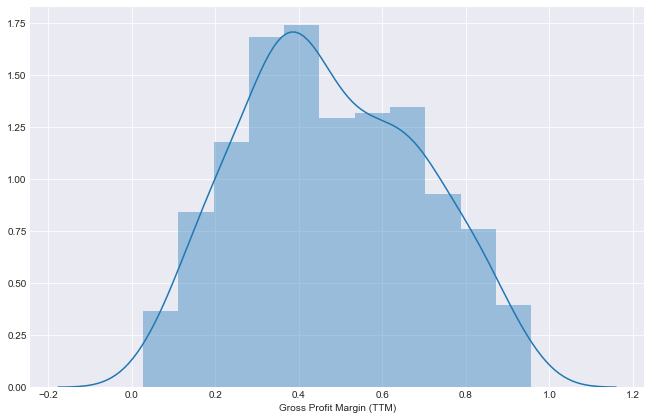

In [41]:
# I'd like to see what the distribution of Gross Profit Margin is, to see if it can be negative
sns.distplot(X['Gross Profit Margin (TTM)'].dropna())

In [42]:
X['Gross Profit Margin (TTM)'].describe()

count    422.000000
mean       0.477298
std        0.214428
min        0.027000
25%        0.320150
50%        0.454150
75%        0.641725
max        0.956300
Name: Gross Profit Margin (TTM), dtype: float64

In [43]:
# As we can see, there are no negative values for Gross Profit Margin, meaning that companies
# that are missing values in this field are probably operating at a loss. This column should
# be binned.

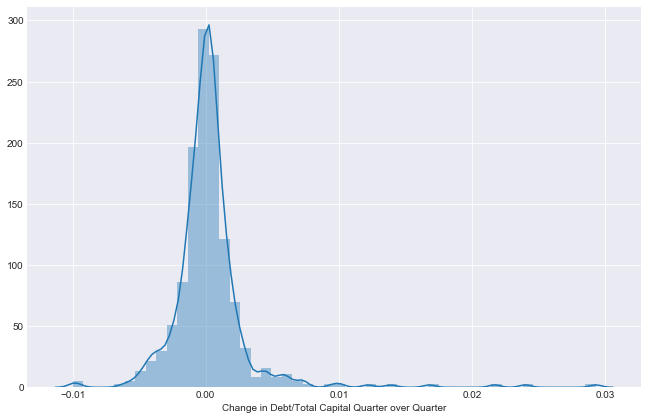

In [44]:
sns.distplot(X['Change in Debt/Total Capital Quarter over Quarter'].dropna())

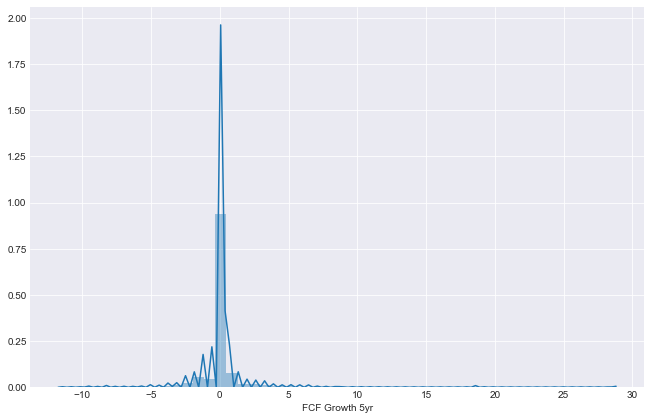

In [45]:
# Let's look at FCF growth for binnability
sns.distplot(X['FCF Growth 5yr'].dropna())

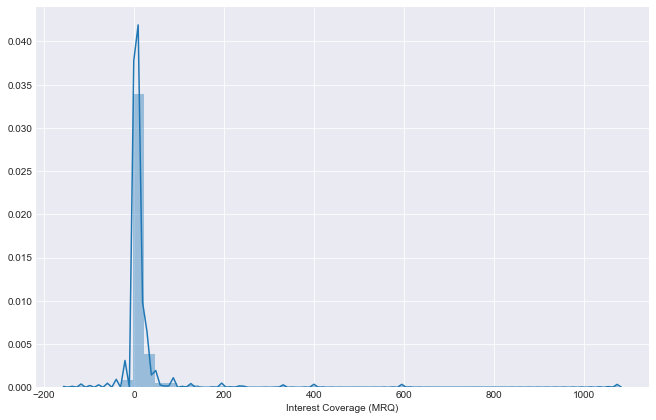

In [46]:
# And at interest coverage
sns.distplot(X['Interest Coverage (MRQ)'].dropna());

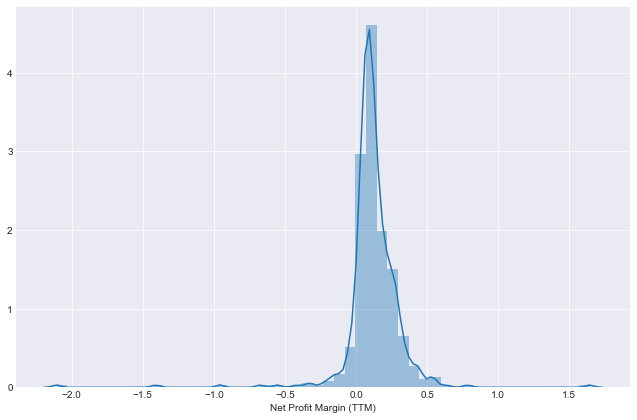

In [47]:
sns.distplot(X['Net Profit Margin (TTM)'].dropna());

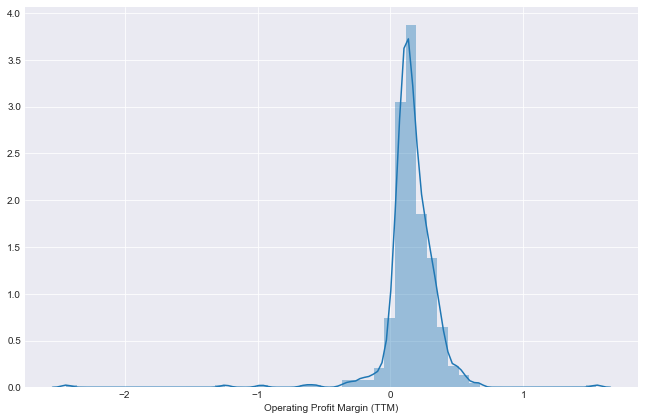

In [48]:
# We can see that net profit margin does go negative, and that the missing values are
# not present for some other reason. It may be better to drop these.
sns.distplot(X['Operating Profit Margin (TTM)'].dropna());

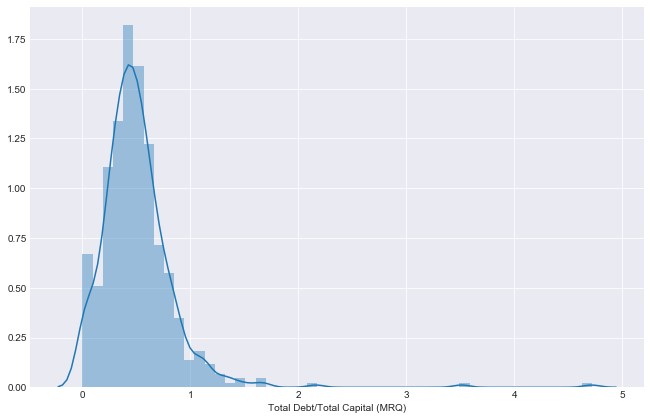

In [49]:
# The same is true for operating profit margin, except these columns are missing the same
# number of values so perhaps binning is the best move forward. There are not that many missing
# values, however, so first I will try dropping
# Checking another feature
sns.distplot(X['Total Debt/Total Capital (MRQ)'].dropna());

In [50]:
# Let's make a list of variables to bin just for the record:
to_bin = ['Annual Dividend %',
          'Dividend Change %',
          'Dividend Growth 5yr',
          'Dividend Growth Rate, 3 Years',
          'EPS (TTM, GAAP)',
          'EPS Growth (MRQ)',
          'EPS Growth (TTM)',
          'EPS Growth 5yr',
          #'FCF Growth 5yr',
          'Gross Profit Margin (TTM)',
          'Interest Coverage (MRQ)'
         ]

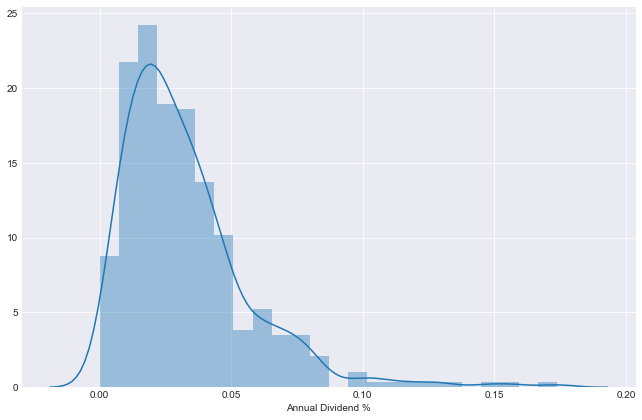

In [51]:
sns.distplot(X['Annual Dividend %'].dropna())

In [52]:
# testing cut with missing values:
test = pd.cut(X['Annual Dividend %'], 10)
test

A       (2.63e-05, 0.0176]
AAL                    NaN
AAP     (2.63e-05, 0.0176]
AAPL    (2.63e-05, 0.0176]
ABBV      (0.0523, 0.0697]
               ...        
YUM       (0.0176, 0.0349]
ZBH     (2.63e-05, 0.0176]
ZBRA                   NaN
ZION      (0.0349, 0.0523]
ZTS     (2.63e-05, 0.0176]
Name: Annual Dividend %, Length: 501, dtype: category
Categories (10, interval[float64]): [(2.63e-05, 0.0176] < (0.0176, 0.0349] < (0.0349, 0.0523] < (0.0523, 0.0697] ... (0.104, 0.122] < (0.122, 0.139] < (0.139, 0.157] < (0.157, 0.174]]

In [53]:
pd.Series(np.where(test.isnull(), 'missing', test)).astype('category')

0      (2.63e-05, 0.0176]
1                 missing
2      (2.63e-05, 0.0176]
3      (2.63e-05, 0.0176]
4        (0.0523, 0.0697]
              ...        
496      (0.0176, 0.0349]
497    (2.63e-05, 0.0176]
498               missing
499      (0.0349, 0.0523]
500    (2.63e-05, 0.0176]
Length: 501, dtype: category
Categories (11, object): [(2.63e-05, 0.0176], (0.0176, 0.0349], (0.0349, 0.0523], (0.0523, 0.0697], ..., (0.122, 0.139], (0.139, 0.157], (0.157, 0.174], missing]

In [54]:
# Now that we have a system of creating categorical variables to deal with columns which had
# missing values that would actually provide information, we can create them iteratively.
X2 = X.copy()
for col in to_bin:
    binned = pd.cut(X2[col], 10)
    X2[col + ' Cats'] = pd.Series(np.where(binned.isnull(), 'missing', binned), index=X2.index).astype('category')

X2 = X2.drop(columns=to_bin)

In [55]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 53 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
Beta                                                 488 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Days to Cover                                        495 non-null float64
FCF Growth 5yr                                       485 non-null float64
Float                                                495 non-null float64
Growth 1yr Consensus Est                             475 non-null float64
Growth 1yr High Est                                  475 non-null float64
Growth 1yr Low Est                                   475 non-null float64
Growth 2yr Consensus Est                             497 non-null float64
Growth 2yr High Est                                  497 non-null float64
Growth 2yr L

In [56]:
# Now we need to deal with the Price ratios
to_fix = ['Price/Book (MRQ)',
          'Price/Cash Flow (TTM)',
          'Price/Earnings (TTM)',
          'Price/Sales (TTM)'
         ]

In [57]:
[ticker for ticker in X2.index if ticker not in sp500_close.columns]

['AGN']

In [58]:
# Need to drop 'AGN' from our tickers
X2 = X2.drop('AGN', axis=0)

In [59]:
for col in to_fix:
    X2[col.replace('Price/','')] = sp500_close.iloc[0].T.loc[X2.index] / X2[col]

X3 = X2.copy().drop(columns=to_fix)
X3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, A to ZTS
Data columns (total 53 columns):
% Held by Institutions                               494 non-null float64
5yr Avg Return                                       500 non-null float64
Beta                                                 487 non-null float64
Change in Debt/Total Capital Quarter over Quarter    472 non-null float64
Days to Cover                                        494 non-null float64
FCF Growth 5yr                                       484 non-null float64
Float                                                494 non-null float64
Growth 1yr Consensus Est                             474 non-null float64
Growth 1yr High Est                                  474 non-null float64
Growth 1yr Low Est                                   474 non-null float64
Growth 2yr Consensus Est                             496 non-null float64
Growth 2yr High Est                                  496 non-null float64
Growth 2yr L

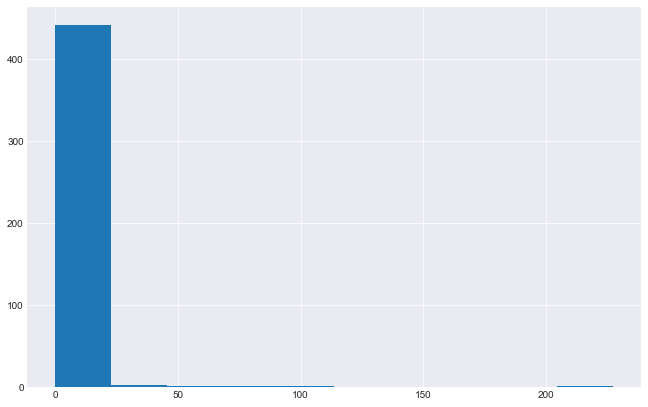

In [60]:
X2['Earnings (TTM)'].hist()

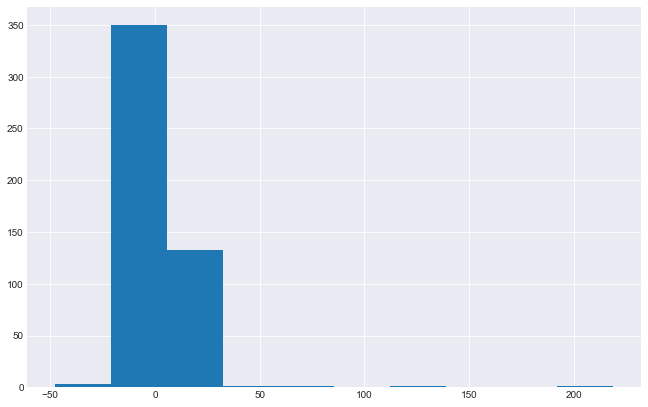

In [61]:
X['EPS (TTM, GAAP)'].hist()

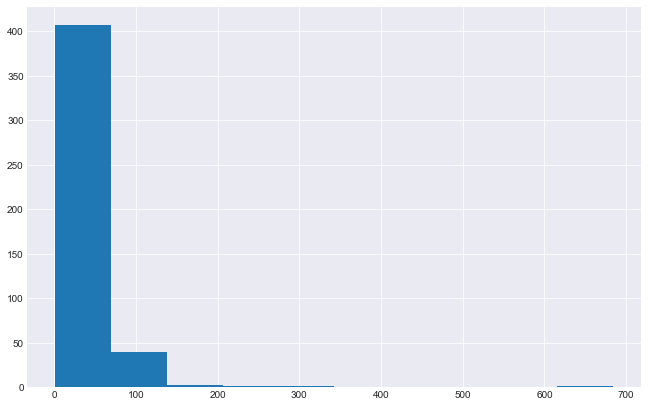

In [62]:
# Interestingly, these are quite different. Let's look at another feature just calculated
X2['Book (MRQ)'].hist()

In [63]:
X3.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, A to ZTS
Data columns (total 53 columns):
% Held by Institutions                               240 non-null float64
5yr Avg Return                                       240 non-null float64
Beta                                                 240 non-null float64
Change in Debt/Total Capital Quarter over Quarter    240 non-null float64
Days to Cover                                        240 non-null float64
FCF Growth 5yr                                       240 non-null float64
Float                                                240 non-null float64
Growth 1yr Consensus Est                             240 non-null float64
Growth 1yr High Est                                  240 non-null float64
Growth 1yr Low Est                                   240 non-null float64
Growth 2yr Consensus Est                             240 non-null float64
Growth 2yr High Est                                  240 non-null float64
Growth 2yr L

In [64]:
X3[X3.columns[X3.isnull().any()]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, A to ZTS
Data columns (total 40 columns):
% Held by Institutions                               494 non-null float64
Beta                                                 487 non-null float64
Change in Debt/Total Capital Quarter over Quarter    472 non-null float64
Days to Cover                                        494 non-null float64
FCF Growth 5yr                                       484 non-null float64
Float                                                494 non-null float64
Growth 1yr Consensus Est                             474 non-null float64
Growth 1yr High Est                                  474 non-null float64
Growth 1yr Low Est                                   474 non-null float64
Growth 2yr Consensus Est                             496 non-null float64
Growth 2yr High Est                                  496 non-null float64
Growth 2yr Low Est                                   496 non-null float64
Growth 3yr H

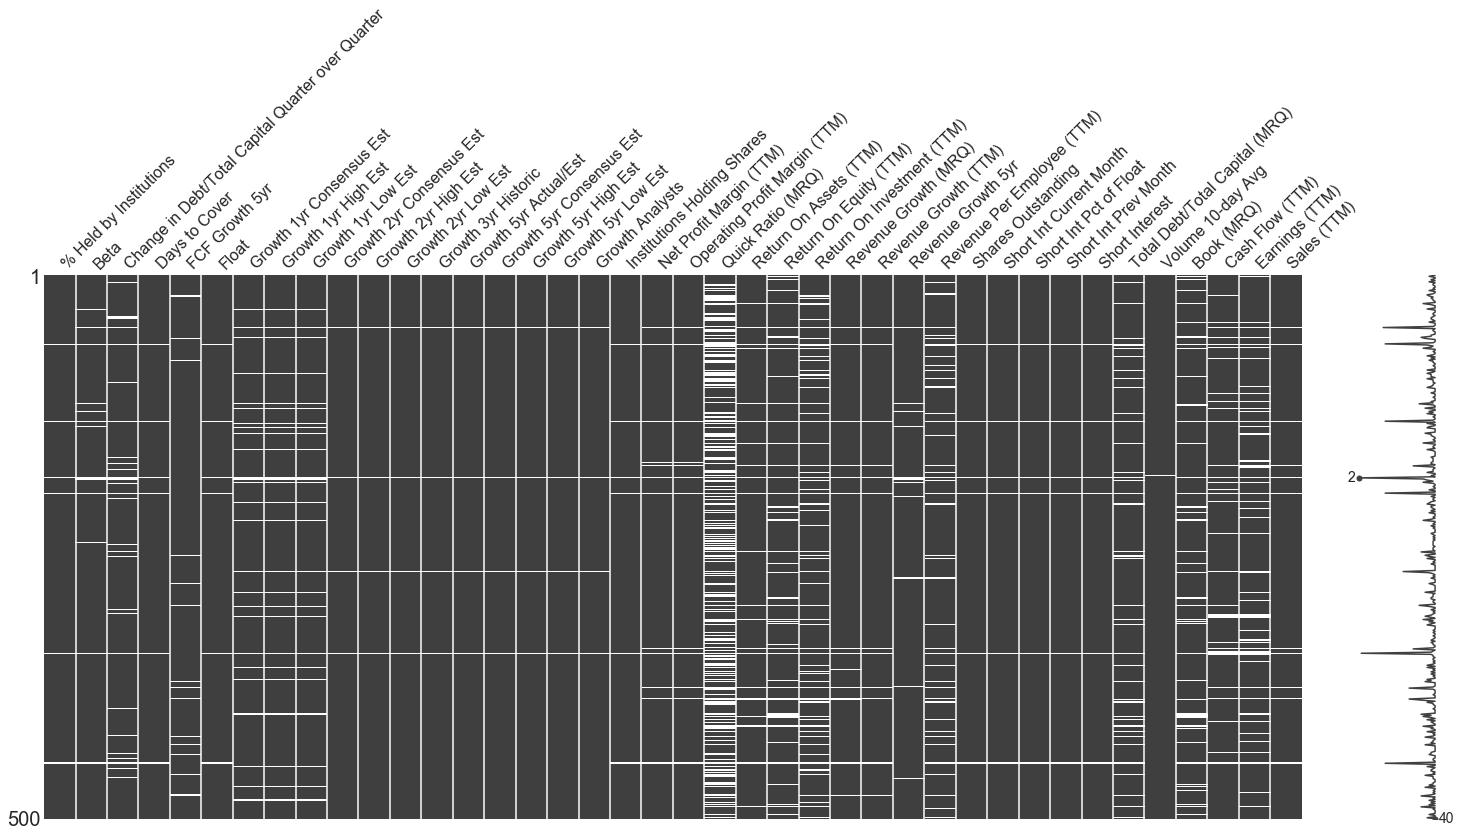

In [65]:
# We have improved our situation, but not by enough. Let's look again at the sparsity of data
msno.matrix(X3[X3.columns[X3.isnull().any()]].copy())

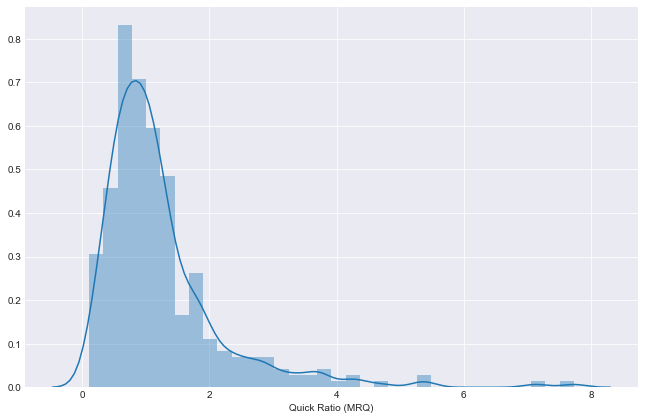

In [66]:
# Quick Ratio has a lot of missing values
sns.distplot(X3['Quick Ratio (MRQ)'].dropna())

In [67]:
len(X3.columns)

53

In [68]:
# Number of columns not missing values
len(X3.columns) - len(X3[X3.columns[X3.isnull().any()]].columns)

13

In [69]:
X3.isnull().sum(axis=1).sort_values(ascending=False)[:15]

FOX      38
NWS      37
ARNC     26
UA       25
DISCK    25
GOOG     25
BIIB     25
L        16
PRU      13
RE       13
NUE      11
FCX      11
CTVA      8
MET       8
JKHY      7
dtype: int64

In [70]:
to_bin = ['Quick Ratio (MRQ)',
          'Growth 1yr Consensus Est',
          'Change in Debt/Total Capital Quarter over Quarter',
          'Return On Assets (TTM)',
          'Return On Equity (TTM)',
          'Return On Investment (TTM)',
          'Revenue Per Employee (TTM)',
          'Total Debt/Total Capital (MRQ)',
          'Book (MRQ)',
          'Cash Flow (TTM)',
          'Earnings (TTM)',
         ]

X4 = X3.copy()
for col in to_bin:
    binned = pd.cut(X2[col], 10)
    X4[col + ' Cats'] = pd.Series(np.where(binned.isnull(), 'missing', binned), index=X2.index).astype('category')

X4 = X4.drop(columns=to_bin)
X4 = X4.drop(columns=['Growth 1yr High Est',
                      'Growth 1yr Low Est'
                     ])
X4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, A to ZTS
Data columns (total 51 columns):
% Held by Institutions                                    494 non-null float64
5yr Avg Return                                            500 non-null float64
Beta                                                      487 non-null float64
Days to Cover                                             494 non-null float64
FCF Growth 5yr                                            484 non-null float64
Float                                                     494 non-null float64
Growth 2yr Consensus Est                                  496 non-null float64
Growth 2yr High Est                                       496 non-null float64
Growth 2yr Low Est                                        496 non-null float64
Growth 3yr Historic                                       496 non-null float64
Growth 5yr Actual/Est                                     496 non-null float64
Growth 5yr Consensus Est       

In [71]:
X4.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 459 entries, A to ZTS
Data columns (total 51 columns):
% Held by Institutions                                    459 non-null float64
5yr Avg Return                                            459 non-null float64
Beta                                                      459 non-null float64
Days to Cover                                             459 non-null float64
FCF Growth 5yr                                            459 non-null float64
Float                                                     459 non-null float64
Growth 2yr Consensus Est                                  459 non-null float64
Growth 2yr High Est                                       459 non-null float64
Growth 2yr Low Est                                        459 non-null float64
Growth 3yr Historic                                       459 non-null float64
Growth 5yr Actual/Est                                     459 non-null float64
Growth 5yr Consensus Est       

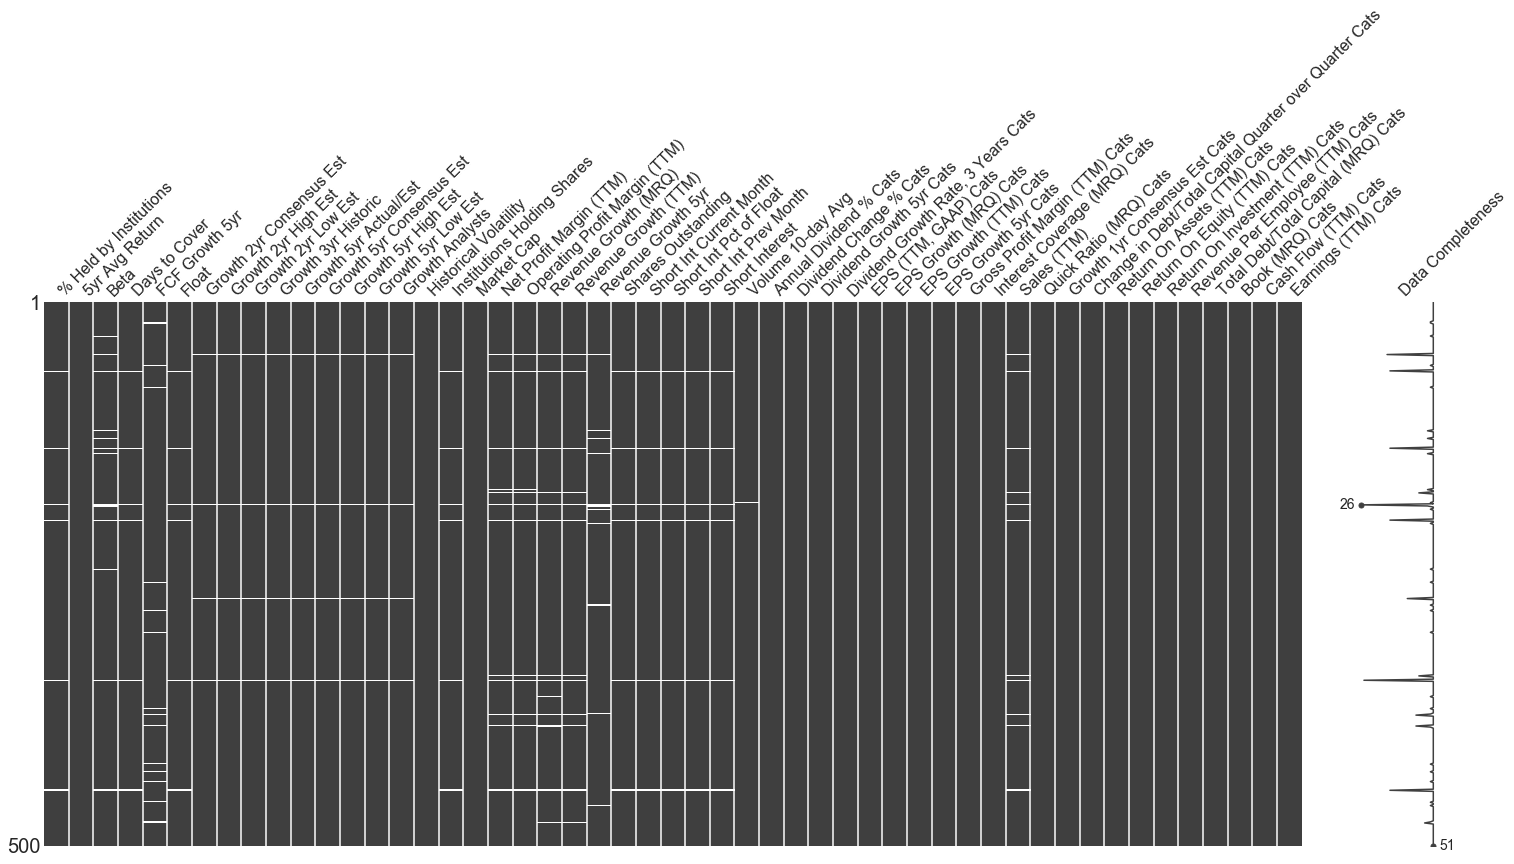

In [72]:
# This is looking much better than before, but not exactly ideal either. Let's take one more
# look at the missingno matrix
msno.matrix(X4, labels=True)

In [73]:
# Let's see what we can do with the data so far, without binning further
X5 = X4.dropna()

In [74]:
data = X5.merge(log_close.iloc[0].T, left_index=True, right_index=True)

In [75]:
# Renaming the target column
colname = data.columns[-1]
data.rename(columns={colname:'log_price'}, inplace=True)
data.head()

,% Held by Institutions,5yr Avg Return,Beta,Days to Cover,FCF Growth 5yr,Float,Growth 2yr Consensus Est,Growth 2yr High Est,Growth 2yr Low Est,Growth 3yr Historic,...,Change in Debt/Total Capital Quarter over Quarter Cats,Return On Assets (TTM) Cats,Return On Equity (TTM) Cats,Return On Investment (TTM) Cats,Revenue Per Employee (TTM) Cats,Total Debt/Total Capital (MRQ) Cats,Book (MRQ) Cats,Cash Flow (TTM) Cats,Earnings (TTM) Cats,log_price
A,0.8499,0.127567,1.1,2.41083,-0.029725,308.50890,0.087999,0.133081,0.042917,0.074225,...,"(0.00179, 0.00572]","(0.0424, 0.156]","(-2.845, 3.606]","(-0.0153, 0.134]","(11769.848, 3621323.2]","(-0.00472, 0.472]","(0.558, 69.531]","(0.000833, 25.325]","(-0.195, 22.77]",4.374496
AAL,0.8162,-0.171550,1.8,1.04128,0.970824,417.91770,-2.671850,-2.008852,-3.334849,0.002325,...,"(-0.00214, 0.00179]","(-0.0712, 0.0424]",missing,"(-0.165, -0.0153]","(11769.848, 3621323.2]","(0.943, 1.415]",missing,"(0.000833, 25.325]",missing,2.316488
AAP,1.0080,0.019850,1.3,1.42372,0.176037,68.85382,0.088077,0.143638,0.032517,0.119104,...,"(-0.00607, -0.00214]","(0.0424, 0.156]","(-2.845, 3.606]","(-0.0153, 0.134]","(11769.848, 3621323.2]","(-0.00472, 0.472]","(0.558, 69.531]","(0.000833, 25.325]","(-0.195, 22.77]",4.822029
AAPL,0.5986,0.214367,1.2,0.90492,-0.021708,4321.13500,0.117766,0.193309,0.042223,0.072870,...,"(-0.00214, 0.00179]","(0.156, 0.27]","(-2.845, 3.606]","(0.134, 0.284]","(11769.848, 3621323.2]","(0.472, 0.943]","(0.558, 69.531]","(0.000833, 25.325]","(-0.195, 22.77]",4.347172
ABBV,0.7329,0.064350,0.8,9.11522,0.145794,1475.02300,0.084456,0.106217,0.062695,0.135679,...,"(-0.00214, 0.00179]","(0.0424, 0.156]",missing,"(0.134, 0.284]","(11769.848, 3621323.2]","(0.943, 1.415]",missing,"(0.000833, 25.325]","(-0.195, 22.77]",4.404683


In [76]:
import my_functions as mf

In [77]:
# Must remove all spaces from column names
colnames = [col.replace(' ','_') for col in data.columns]
data.columns = colnames

In [78]:
data.columns

Index(['%_Held_by_Institutions', '5yr_Avg_Return', 'Beta', 'Days_to_Cover',
       'FCF_Growth_5yr', 'Float', 'Growth_2yr_Consensus_Est',
       'Growth_2yr_High_Est', 'Growth_2yr_Low_Est', 'Growth_3yr_Historic',
       'Growth_5yr_Actual/Est', 'Growth_5yr_Consensus_Est',
       'Growth_5yr_High_Est', 'Growth_5yr_Low_Est', 'Growth_Analysts',
       'Historical_Volatility', 'Institutions_Holding_Shares', 'Market_Cap',
       'Net_Profit_Margin_(TTM)', 'Operating_Profit_Margin_(TTM)',
       'Revenue_Growth_(MRQ)', 'Revenue_Growth_(TTM)', 'Revenue_Growth_5yr',
       'Shares_Outstanding', 'Short_Int_Current_Month',
       'Short_Int_Pct_of_Float', 'Short_Int_Prev_Month', 'Short_Interest',
       'Volume_10-day_Avg', 'Annual_Dividend_%_Cats', 'Dividend_Change_%_Cats',
       'Dividend_Growth_5yr_Cats', 'Dividend_Growth_Rate,_3_Years_Cats',
       'EPS_(TTM,_GAAP)_Cats', 'EPS_Growth_(MRQ)_Cats',
       'EPS_Growth_(TTM)_Cats', 'EPS_Growth_5yr_Cats',
       'Gross_Profit_Margin_(TTM)_Cats',

In [79]:
data.rename(columns={'%_Held_by_Institutions':'Pct_Held_by_Institutions',
                     '5yr_Avg_Return':'Avg_Return_5yr'
                    }, inplace=True)

In [80]:
# Must remove all spaces from column names
colnames = [col.replace('(','')\
            .replace(')','')\
            .replace('/','_')\
            .replace(',','')\
            .replace('%','Pct')\
            .replace('-','_') for col in data.columns]
data.columns = colnames

In [81]:
data.columns

Index(['Pct_Held_by_Institutions', 'Avg_Return_5yr', 'Beta', 'Days_to_Cover',
       'FCF_Growth_5yr', 'Float', 'Growth_2yr_Consensus_Est',
       'Growth_2yr_High_Est', 'Growth_2yr_Low_Est', 'Growth_3yr_Historic',
       'Growth_5yr_Actual_Est', 'Growth_5yr_Consensus_Est',
       'Growth_5yr_High_Est', 'Growth_5yr_Low_Est', 'Growth_Analysts',
       'Historical_Volatility', 'Institutions_Holding_Shares', 'Market_Cap',
       'Net_Profit_Margin_TTM', 'Operating_Profit_Margin_TTM',
       'Revenue_Growth_MRQ', 'Revenue_Growth_TTM', 'Revenue_Growth_5yr',
       'Shares_Outstanding', 'Short_Int_Current_Month',
       'Short_Int_Pct_of_Float', 'Short_Int_Prev_Month', 'Short_Interest',
       'Volume_10_day_Avg', 'Annual_Dividend_Pct_Cats',
       'Dividend_Change_Pct_Cats', 'Dividend_Growth_5yr_Cats',
       'Dividend_Growth_Rate_3_Years_Cats', 'EPS_TTM_GAAP_Cats',
       'EPS_Growth_MRQ_Cats', 'EPS_Growth_TTM_Cats', 'EPS_Growth_5yr_Cats',
       'Gross_Profit_Margin_TTM_Cats', 'Interest_C

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, A to ZTS
Data columns (total 52 columns):
Pct_Held_by_Institutions                                  458 non-null float64
Avg_Return_5yr                                            458 non-null float64
Beta                                                      458 non-null float64
Days_to_Cover                                             458 non-null float64
FCF_Growth_5yr                                            458 non-null float64
Float                                                     458 non-null float64
Growth_2yr_Consensus_Est                                  458 non-null float64
Growth_2yr_High_Est                                       458 non-null float64
Growth_2yr_Low_Est                                        458 non-null float64
Growth_3yr_Historic                                       458 non-null float64
Growth_5yr_Actual_Est                                     458 non-null float64
Growth_5yr_Consensus_Est       

In [83]:
data.isna().sum()

Pct_Held_by_Institutions                                  0
Avg_Return_5yr                                            0
Beta                                                      0
Days_to_Cover                                             0
FCF_Growth_5yr                                            0
Float                                                     0
Growth_2yr_Consensus_Est                                  0
Growth_2yr_High_Est                                       0
Growth_2yr_Low_Est                                        0
Growth_3yr_Historic                                       0
Growth_5yr_Actual_Est                                     0
Growth_5yr_Consensus_Est                                  0
Growth_5yr_High_Est                                       0
Growth_5yr_Low_Est                                        0
Growth_Analysts                                           0
Historical_Volatility                                     0
Institutions_Holding_Shares             

In [84]:
# Let's see if we can get a dirty linear regression to test our dataset
xcols = data.columns[:-1]
mf.do_a_linreg(data, xcols, 'log_price')

Linear Regression for log_price~Pct_Held_by_Institutions+Avg_Return_5yr+Beta+Days_to_Cover+FCF_Growth_5yr+Float+Growth_2yr_Consensus_Est+Growth_2yr_High_Est+Growth_2yr_Low_Est+Growth_3yr_Historic+Growth_5yr_Actual_Est+Growth_5yr_Consensus_Est+Growth_5yr_High_Est+Growth_5yr_Low_Est+Growth_Analysts+Historical_Volatility+Institutions_Holding_Shares+Market_Cap+Net_Profit_Margin_TTM+Operating_Profit_Margin_TTM+Revenue_Growth_MRQ+Revenue_Growth_TTM+Revenue_Growth_5yr+Shares_Outstanding+Short_Int_Current_Month+Short_Int_Pct_of_Float+Short_Int_Prev_Month+Short_Interest+Volume_10_day_Avg+Annual_Dividend_Pct_Cats+Dividend_Change_Pct_Cats+Dividend_Growth_5yr_Cats+Dividend_Growth_Rate_3_Years_Cats+EPS_TTM_GAAP_Cats+EPS_Growth_MRQ_Cats+EPS_Growth_TTM_Cats+EPS_Growth_5yr_Cats+Gross_Profit_Margin_TTM_Cats+Interest_Coverage_MRQ_Cats+Sales_TTM+Quick_Ratio_MRQ_Cats+Growth_1yr_Consensus_Est_Cats+Change_in_Debt_Total_Capital_Quarter_over_Quarter_Cats+Return_On_Assets_TTM_Cats+Return_On_Equity_TTM_Cats+Ret

MissingDataError: exog contains inf or nans

In [85]:
# Looks like we have some infs in the data that weren't noticed before
data[data == np.inf].sum()

Pct_Held_by_Institutions                                  0.0
Avg_Return_5yr                                            0.0
Beta                                                      0.0
Days_to_Cover                                             0.0
FCF_Growth_5yr                                            0.0
Float                                                     0.0
Growth_2yr_Consensus_Est                                  inf
Growth_2yr_High_Est                                       0.0
Growth_2yr_Low_Est                                        inf
Growth_3yr_Historic                                       0.0
Growth_5yr_Actual_Est                                     0.0
Growth_5yr_Consensus_Est                                  inf
Growth_5yr_High_Est                                       0.0
Growth_5yr_Low_Est                                        inf
Growth_Analysts                                           0.0
Historical_Volatility                                     0.0
Institut

In [86]:
data['Growth_2yr_Consensus_Est'].describe()

count    458.000000
mean            inf
std             NaN
min      -53.573755
25%       -0.038005
50%        0.039837
75%        0.098045
max             inf
Name: Growth_2yr_Consensus_Est, dtype: float64

In [87]:
data['Growth_2yr_Consensus_Est'].sort_values(ascending=False).head()

AXP           inf
APTV    14.267208
ALGN    10.720141
INCY     7.722339
CMG      6.346933
Name: Growth_2yr_Consensus_Est, dtype: float64

In [88]:
data['Growth_2yr_Low_Est'].sort_values(ascending=False).head()

AXP           inf
APTV    28.405400
ALGN    21.165996
CMG     12.223359
UDR     12.000000
Name: Growth_2yr_Low_Est, dtype: float64

In [89]:
data['Growth_5yr_Low_Est'].sort_values(ascending=False).head()

AXP           inf
APTV    14.210748
ALGN    14.145788
UDR     12.000000
CMG      6.403743
Name: Growth_5yr_Low_Est, dtype: float64

In [90]:
# It seems as though AXP is the only problem here, we will just drop it and continue
data = data.drop('AXP', axis=0)

Linear Regression for log_price~Pct_Held_by_Institutions+Avg_Return_5yr+Beta+Days_to_Cover+FCF_Growth_5yr+Float+Growth_2yr_Consensus_Est+Growth_2yr_High_Est+Growth_2yr_Low_Est+Growth_3yr_Historic+Growth_5yr_Actual_Est+Growth_5yr_Consensus_Est+Growth_5yr_High_Est+Growth_5yr_Low_Est+Growth_Analysts+Historical_Volatility+Institutions_Holding_Shares+Market_Cap+Net_Profit_Margin_TTM+Operating_Profit_Margin_TTM+Revenue_Growth_MRQ+Revenue_Growth_TTM+Revenue_Growth_5yr+Shares_Outstanding+Short_Int_Current_Month+Short_Int_Pct_of_Float+Short_Int_Prev_Month+Short_Interest+Volume_10_day_Avg+Annual_Dividend_Pct_Cats+Dividend_Change_Pct_Cats+Dividend_Growth_5yr_Cats+Dividend_Growth_Rate_3_Years_Cats+EPS_TTM_GAAP_Cats+EPS_Growth_MRQ_Cats+EPS_Growth_TTM_Cats+EPS_Growth_5yr_Cats+Gross_Profit_Margin_TTM_Cats+Interest_Coverage_MRQ_Cats+Sales_TTM+Quick_Ratio_MRQ_Cats+Growth_1yr_Consensus_Est_Cats+Change_in_Debt_Total_Capital_Quarter_over_Quarter_Cats+Return_On_Assets_TTM_Cats+Return_On_Equity_TTM_Cats+Ret

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1452: RuntimeWarning: i

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 11 Nov 2020   Prob (F-statistic):                nan
Time:                        11:24:41   Log-Likelihood:                 6294.5
No. Observations:                 457   AIC:                        -1.168e+04
Df Residuals:                       0   BIC:                            -9790.
Df Model:                         456                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================================
                                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                 11.7336        inf          0        nan         nan         nan
Market_Cap[T.1.3T]                                                                                         2.7107        inf          0        nan         nan         nan
Market_Cap[T.1.4T]                                                                                        22.6973        inf          0        nan         nan         nan
Market_Cap[T.1.7B]                                                                                         0.1974        inf          0        nan         nan         nan
Market_Cap[T.1.9B]                                                                                        -3.1488        inf         -0        nan         nan         nan
Market_Cap[T.10.3B]                                                                                       -1.6552        inf         -0        nan         nan         nan
Market_Cap[T.10.4B]                                                                                       -2.9292        inf         -0        nan         nan         nan
Market_Cap[T.10.5B]                                                                                       -1.7360        inf         -0        nan         nan         nan
Market_Cap[T.10.7B]                                                                                       -1.6951        inf         -0        nan         nan         nan
Market_Cap[T.10.8B]                                                                                       -0.7441        inf         -0        nan         nan         nan
Market_Cap[T.10.9B]                                                                                        0.5864        inf          0        nan         nan         nan
Market_Cap[T.105.5B]                                                                                       5.2075        inf          0        nan         nan         nan
Market_Cap[T.105.7B]                                                                                      -0.6071        inf         -0        nan         nan         nan
Market_Cap[T.106.1B]                                                                                      -0.5107        inf         -0        nan         nan         nan
Market_Cap[T.106.4B]                                                                                      -1.5050        inf         -0        nan         nan         nan
Marke

Test for homoscedasticity of residuals:


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,F_statistic,p_value
Goldfeld-Quandt,NaN,NaN


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 4.999998e-01 
 5.062102e-01 
 
 
 p-value 
 3.587113e-106 
 1.014406e-33 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 52.538251 
 0.78 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 139714.074518 
 
 
 p-value 
 0.000000 
 
 
 Skew 
 -7.252398 
 
 
 Kurtosis 
 87.420926

Skew: -7.2523980228052105
Kurtosis: 84.42092574982445


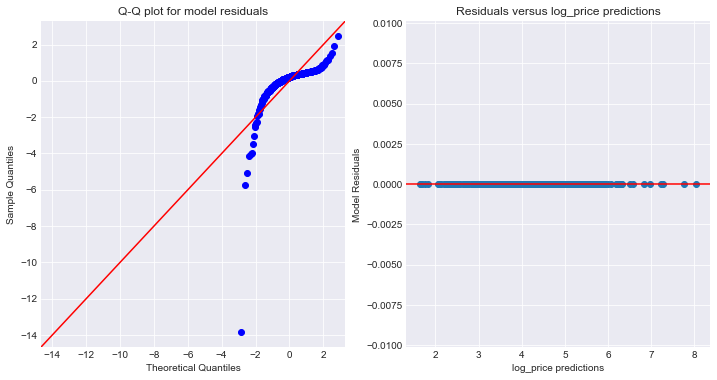

In [91]:
# Let's see if we can get a dirty linear regression to test our dataset
xcols = data.columns[:-1]
mf.do_a_linreg(data, xcols, 'log_price')

In [92]:
# We've run into the problem that with all of these categorical variables, there are far more
# features than there are observations. We can use dimensionality reducting when this becomes
# an issue. It is also appropriate to scale a dataset before modeling to compare feature
# importances, and this is also necessary for some dimensionality reduction techniques

### Imputing Data

Apparently, [PCA is only really meaningful using continuous data](https://stackoverflow.com/questions/40795141/pca-for-categorical-features), which we don't have now that we've created all of these categorical variables to make up for the missing data rows.

To solve this problem, imputing data may help greatly. One of the reasons that we've had to do all of these gymnastics with creating categorical variables is because there are missing data values mixed up between many rows (as we recall there were only 77 rows which had all the data available, but on average there were not that many rows missing from any particular feature).

Scikit-learn has imputing capabilities, I will now try to implement some of them.

In [93]:
# First, let's rewind our data transformations to before we started making everything
# categorical
X.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 53 columns):
% Held by Institutions                               495 non-null float64
5yr Avg Return                                       501 non-null float64
Annual Dividend %                                    394 non-null float64
Beta                                                 488 non-null float64
Change in Debt/Total Capital Quarter over Quarter    473 non-null float64
Days to Cover                                        495 non-null float64
Dividend Change %                                    405 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      490 non-null float64
EPS Growth (MRQ)                                     487 non-null float64
EPS Growth (TTM)                                     489 non-null float64
EPS Growth 5

In [94]:
for col in X.columns:
    if np.inf in X[col].values or -np.inf in X[col].values:
        print(col)

Growth 2yr Consensus Est
Growth 2yr Low Est
Growth 5yr Consensus Est
Growth 5yr Low Est


In [95]:
np.inf in X.values or -np.inf in X.values

True

In [96]:
# We can see that there are infs present in the data, let's encode them as NaNs
X = X.replace([np.inf, -np.inf], np.NaN)

In [97]:
# Import some regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [98]:
def get_scores_for_imputer(imputer, X_missing, y_missing, regressor, scoring, scale=True):
    if scale:
        steps = [('scaler', StandardScaler()), 
                 ('imputer', imputer), 
                 ('regressor', regressor)]
    else:
        steps = [('imputer', imputer), 
                 ('regressor', regressor)]
        
    estimator = Pipeline(steps=steps)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring=scoring,
                                    cv=N_SPLITS)
    return impute_scores

def get_impute_zero_score(X_missing, y_missing, regressor, scoring):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, 
                                                X_missing, 
                                                y_missing, 
                                                regressor, 
                                                scoring)
    return zero_impute_scores.mean(), zero_impute_scores.std()

def get_impute_knn_score(X_missing, y_missing, regressor, scoring, n_neighbors=5):
    imputer = KNNImputer(missing_values=np.nan, 
                         add_indicator=True, 
                         n_neighbors=n_neighbors,
                         weights='distance')
    knn_impute_scores = get_scores_for_imputer(imputer, 
                                               X_missing, 
                                               y_missing, 
                                               regressor, 
                                               scoring)
    return knn_impute_scores.mean(), knn_impute_scores.std()

def get_impute_mean(X_missing, y_missing, regressor, scoring):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean",
                            add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, 
                                                X_missing, 
                                                y_missing, 
                                                regressor, 
                                                scoring)
    return mean_impute_scores.mean(), mean_impute_scores.std()

def get_impute_iterative(X_missing, y_missing, regressor, scoring, estimator=None,
                         n_nearest_features=None, max_iter=10
                        ):
    sample_posterior = False
    if 'BayesianRidge' in str(estimator):
        sample_posterior = True
    elif estimator is None:
        n_nearest_features = 5
        sample_posterior = True
        
    #try:
    imputer = IterativeImputer(estimator=estimator,
                               missing_values=np.nan, 
                               max_iter=max_iter,
                               add_indicator=True,
                               random_state=0, 
                               n_nearest_features=n_nearest_features,
                               sample_posterior=sample_posterior
                              )
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing,
                                                     regressor,
                                                     scoring
                                                    )
    
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

In [99]:
# Function to graph results of imputation comparisons
def graph_imputer_scores(scores, stds, labels, scoring, regressor=None, iterative=False):
    n_bars = len(scores)
    xval = np.arange(n_bars)
    
    if regressor is not None:
        name = str(regressor).split('(')[0]
        title_string = ' with {}'.format(name)
    else:
        title_string = ''

    x_labels = labels
    colors = ['r', 'g', 'b', 'orange', 'black']

    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(111)
    for j in xval:
        ax1.barh(j, scores[j], xerr=stds[j],
                 color=colors[j], alpha=0.6, align='center')
    if not iterative:
        ax1.set_title('Imputation Techniques Comparison{}'.format(title_string))
    else:
        ax1.set_title('Iterative Imputation Estimator Comparison{}'.format(title_string))
    ax1.set_xlim(left=np.min(scores*2) * 0.9,
                 right=np.max(scores*2) * 1.1)
    ax1.set_yticks(xval)
    ax1.set_xlabel(scoring)
    ax1.invert_yaxis()
    ax1.set_yticklabels(x_labels)

    return ax1

# Creating a wrapper function to keep code DRY
def compare_imputer_scores(X, y, regressor, scoring, iterative_estimators=None, max_iter=10):
    # Getting scores for these imputers
    zero_scores = get_impute_zero_score(X, y, regressor, scoring)
    mean_scores = get_impute_mean(X, y, regressor, scoring)
    knn_scores = get_impute_knn_score(X, y, regressor, scoring)
    iter_scores = get_impute_iterative(X, y, regressor, scoring, n_nearest_features=5)
    
    scores = [zero_scores[0], mean_scores[0], knn_scores[0], iter_scores[0]]
    stds = [zero_scores[1], mean_scores[1], knn_scores[1], iter_scores[1]]
    
    # Graphing the scores of the imputation methods above
    labels = ['Zero imputation',
              'Mean Imputation',
              'KNN Imputation',
              'Iterative Imputation']
    
    # Now to run through the estimators for IterativeImputer
    results = []

    if iterative_estimators:
        labels2 = []
        for estimator in iterative_estimators:
            name = str(estimator).split('(')[0]
            print('Imputing with IterativeImputer using {} estimator'.format(name))
            labels2.append(name)
            
            n_nearest_features = None
            if 'BayesianRidge' in str(estimator):
                n_nearest_features = 5
                
            results.append(get_impute_iterative(X,
                                                y,
                                                regressor,
                                                scoring,
                                                estimator,
                                                n_nearest_features=n_nearest_features,
                                                max_iter=max_iter
                                              )
                         )
            
        scores2 = [results[i][0] for i in range(len(results))]
        stds2 = [results[i][1] for i in range(len(results))]
    
    ax1 = graph_imputer_scores(scores, stds, labels, scoring, regressor)
    
    if iterative_estimators:
        ax2 = graph_imputer_scores(scores2, stds2, labels2, scoring, regressor, iterative=True)
        return ax1, ax2
        
    return ax1

In [100]:
scaler = StandardScaler()
y = log_close.iloc[0].T.loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


ValueError: could not convert string to float: '24.1B'

In [101]:
# The market cap column is causing trouble because it is in string format. Let's look at it.
X['Market Cap'].head()

A        24.7B
AAL       4.3B
AAP       8.6B
AAPL      1.3T
ABBV    124.0B
Name: Market Cap, dtype: object

In [102]:
# We can see that the last character is a letter representing a multiple
X['Market Cap'].map(lambda x: x[-1]).unique()

array(['B', 'T', 'M'], dtype=object)

In [103]:
# We can then make a function to turn this into a numerical feature
def fix_market_cap(x):
    if x[-1] == 'M':
        x = x.strip('M')
        x = float(x) * 1e6
    elif x[-1] == 'B':
        x = x.strip('B')
        x = float(x) * 1e9
    elif x[-1] == 'T':
        x = x.strip('T')
        x = float(x) * 1e12
    else:
        raise ValueError('Invalid input')
        
    return x

In [104]:
X['marketCap'] = X['Market Cap'].map(fix_market_cap)
X['marketCap'].head()

A       2.470000e+10
AAL     4.300000e+09
AAP     8.600000e+09
AAPL    1.300000e+12
ABBV    1.240000e+11
Name: marketCap, dtype: float64

In [105]:
# There, that's fixed, now to drop original column
X.drop(columns=['Market Cap'], inplace=True)

In [106]:
[colname for colname in X.index if colname not in log_close.columns]

['AGN', 'ETFC']

In [107]:
X_new = X.drop(index=['AGN', 'ETFC'])

In [108]:
# Now we need to deal with the Price ratios, which need to have the prices factored back out
# to avoid having information about the price in the training features
to_fix = ['Price/Book (MRQ)',
          'Price/Cash Flow (TTM)',
          'Price/Earnings (TTM)',
          'Price/Sales (TTM)'
         ]

In [109]:
# The closing prices are along the first row of sp500_close, so we need to isolate the
# row and transpose it, then divide it by each ratio.
for col in to_fix:
    X_new[col.replace('Price/','')] = sp500_close.iloc[0].T.loc[X2.index] / X2[col]

X_new = X_new.drop(columns=to_fix)
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 53 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
Annual Dividend %                                    392 non-null float64
Beta                                                 486 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Days to Cover                                        493 non-null float64
Dividend Change %                                    403 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      488 non-null float64
EPS Growth (MRQ)                                     485 non-null float64
EPS Growth (TTM)                                     487 non-null float64
EPS Growth 5

In [110]:
scaler = StandardScaler()
y = log_close.iloc[0].T.loc[X_new.index]
X_train, X_test, y_train, y_test = train_test_split(X_new, y)
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### LinearRegression

In [111]:
regressor = LinearRegression()

In [112]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

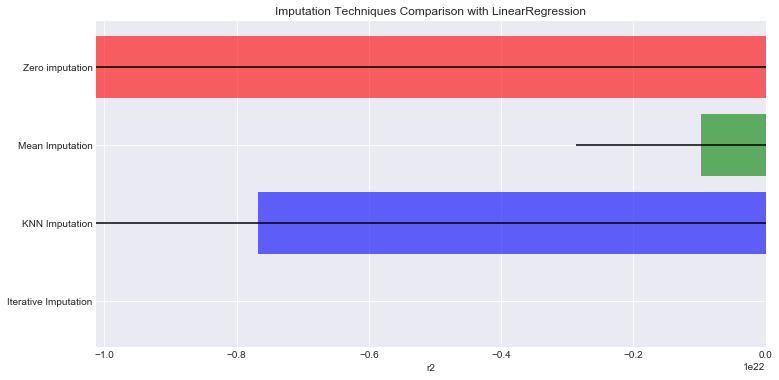

In [451]:
N_SPLITS = 5

ax = compare_imputer_scores(X_new, y, regressor, scoring='r2')

#### RandomForestRegressor

In [453]:
# We can see that old fashioned linear regression has performed dismally here, let's try another
# type of regressor
regressor = RandomForestRegressor(random_state=0)

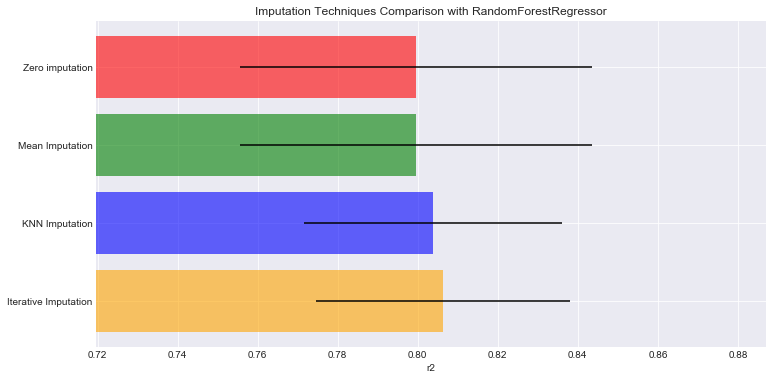

In [454]:
ax = compare_imputer_scores(X_new, y, regressor, scoring='r2')

In [455]:
# We can see that the RandomForestRegressor has performed much better than the LinearRegression,
# with r2 scores around .80, which is pretty good for not having any parameter tuning done
# Running the above using both 'uniform' and 'distance' weights in the KNNImputer revealed that
# the 'distance' weigting method had better results

#### GradientBoostingRegressor

In [113]:
# Let's try this one more time with another regressor
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor()

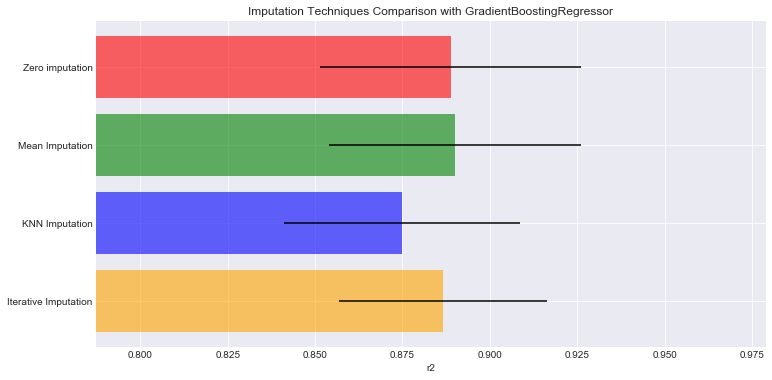

In [457]:
ax1 = compare_imputer_scores(X_new, y, regressor, 'r2')

In [458]:
# These scores are fairly impressive for having started with a dataset full of missing values,
# some of them are appropaching .90. Mean Imputation has performed the best here

In [114]:
# There are some options for IterativeImputer that have not been explored yet. Let's take a look
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [460]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=0),
    RandomForestRegressor(random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using RandomForestRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


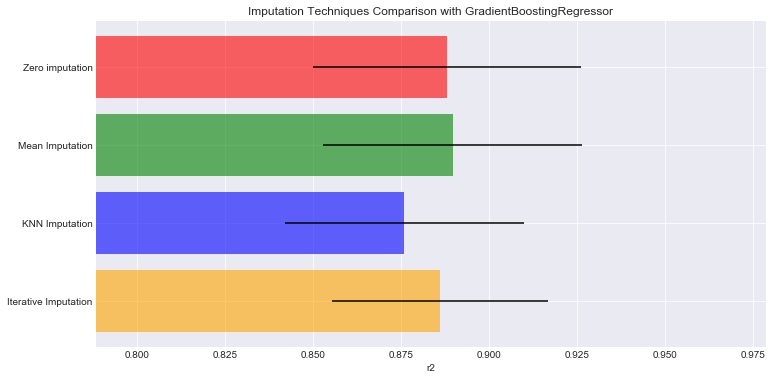

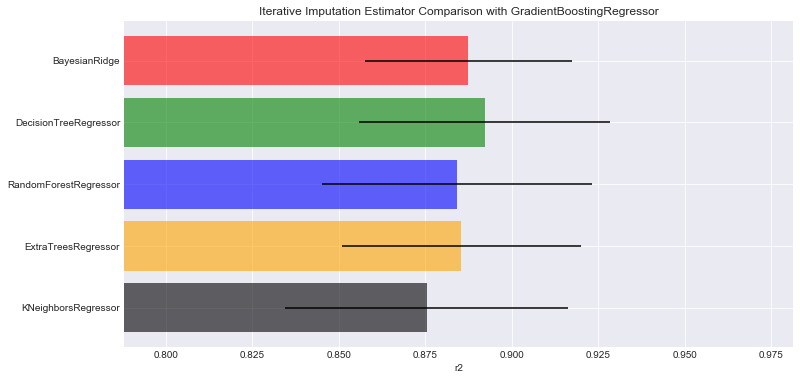

In [461]:
ax1, ax2 = compare_imputer_scores(X_new, 
                                  y,
                                  regressor, 
                                  scoring='r2', 
                                  iterative_estimators=estimators)

In [ ]:
# A note that adding the RandomForest has made this problem take a long time, if they aren't
# much better performing, then it is safe to say they are not worth the extra fitting time

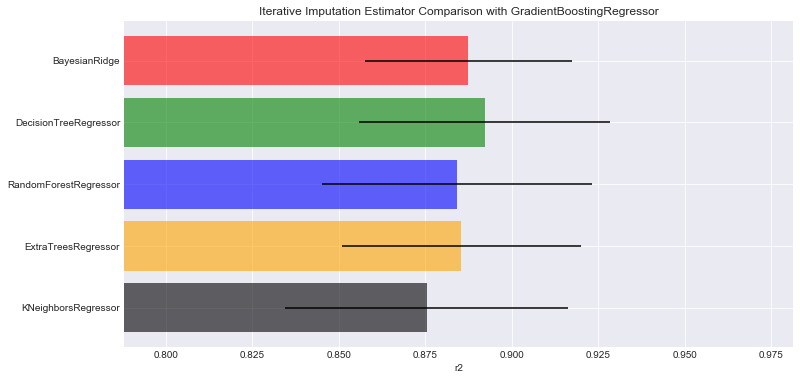

In [463]:
ax2.figure

In [334]:
# The results show that RandomForest is not appreciably better than the others, so it should
# not be used in this context, as it took forever. Let's try tuning other params

In [467]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=0),
    KNeighborsRegressor(n_neighbors=5)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


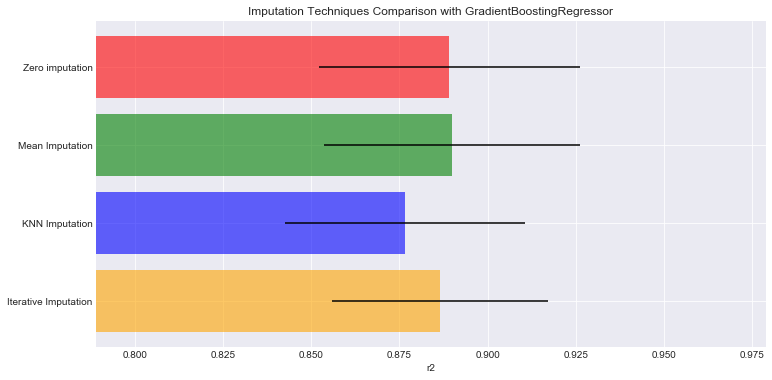

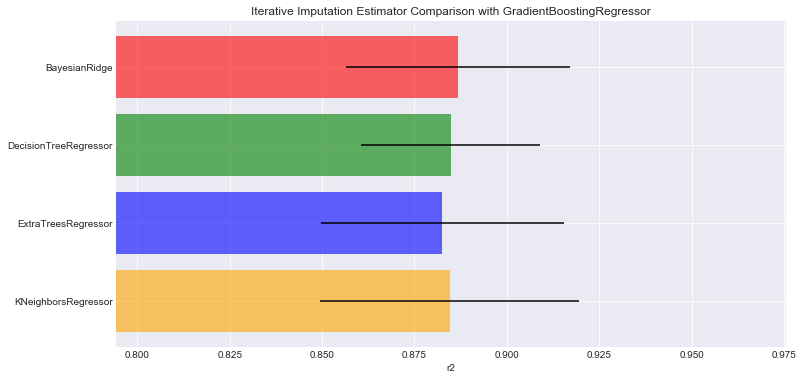

In [468]:
ax1, ax2 = compare_imputer_scores(X_new, 
                                  y, 
                                  regressor, 
                                  scoring='r2',
                                  iterative_estimators=estimators
                                 )

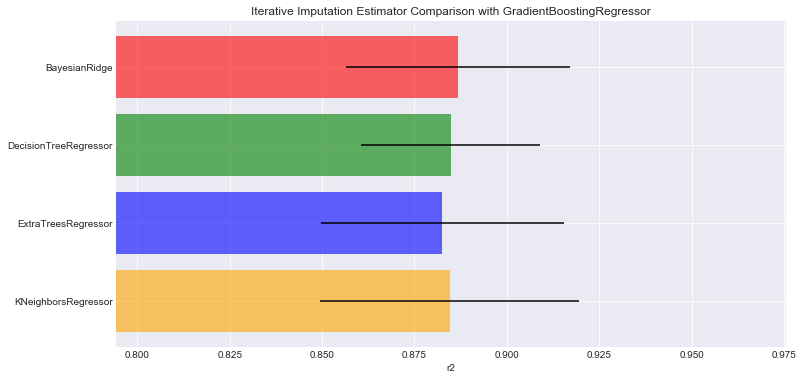

In [469]:
ax2.figure

In [470]:
# We can see that the DecisionTreeRegressor has suffered due to the change in max_features
# KNeighborsRegressor has done better using 5 neighbors rather than 15
# Let's change some hyperparameters again and see how things differ

In [471]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='log2', random_state=0),
    ExtraTreesRegressor(n_estimators=20, max_features='sqrt', random_state=0),
    KNeighborsRegressor(n_neighbors=30)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


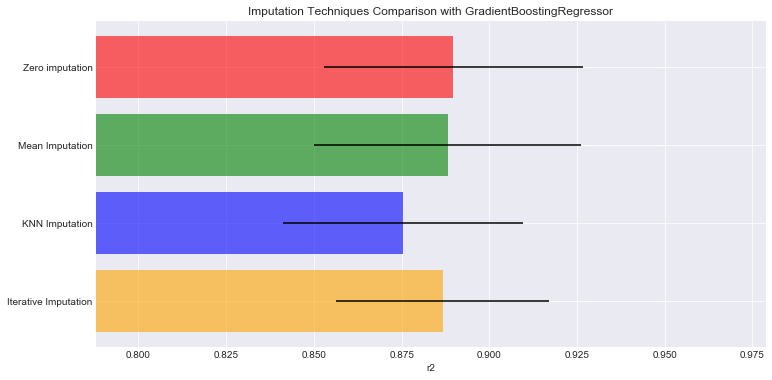

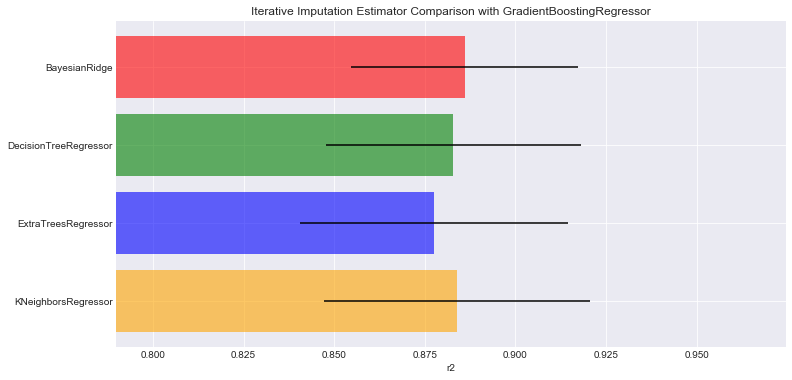

In [472]:
ax1, ax2 = compare_imputer_scores(X_new, 
                                  y, 
                                  regressor, 
                                  scoring='r2',
                                  iterative_estimators=estimators
                                 )

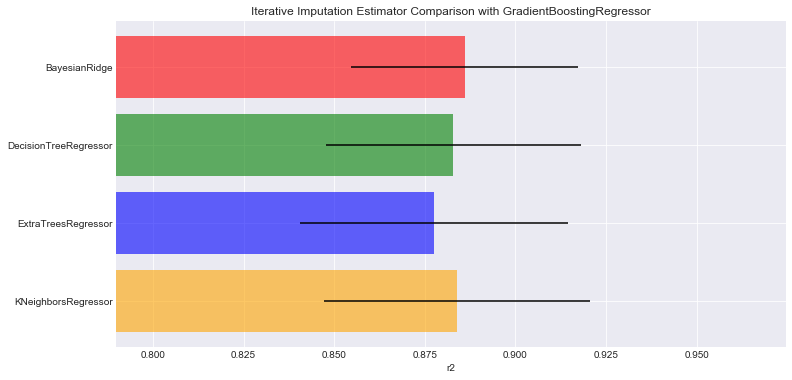

In [473]:
ax2.figure

In [ ]:
# These results are basically the same as before. A bit more performance in KNeighbors by
# increasing the number of neighbors in the KNeighbors estimator.

In [474]:
# The best results so far have been attained with the IterativeImputer using the
# DecisionTreeRegressor estimator, though they are not much higher than the mean imputation,
# which is computationally much simpler

#### XGBRegressor

In [115]:
# Now to try the regresors from the xgboost package
from xgboost import XGBRegressor, XGBRFRegressor

In [482]:
regressor = XGBRegressor(objective='reg:squarederror')

In [483]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=0),
    ExtraTreesRegressor(n_estimators=10, max_features='auto', random_state=0),
    KNeighborsRegressor(n_neighbors=5)
]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

Imputing with IterativeImputer using BayesianRidge estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-package

Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-package

Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-package

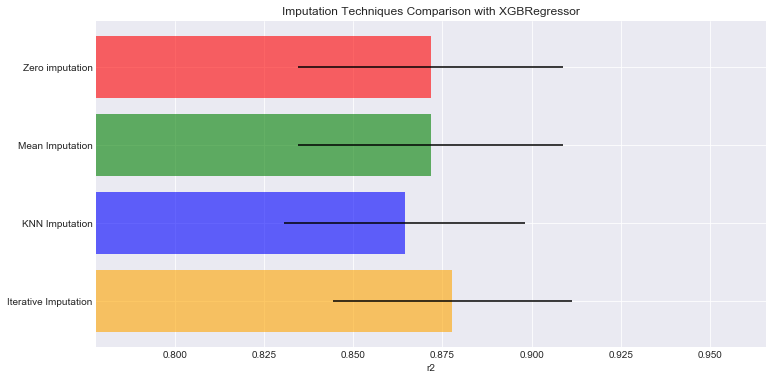

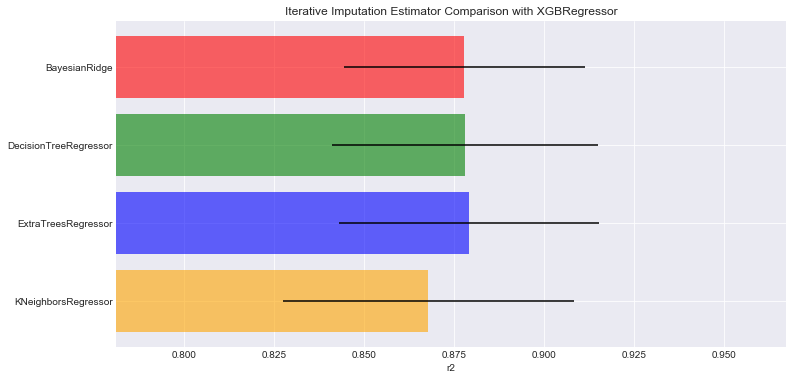

In [484]:
ax1, ax2 = compare_imputer_scores(X_new, 
                                  y, 
                                  regressor, 
                                  scoring='r2',
                                  iterative_estimators=estimators
                                 )

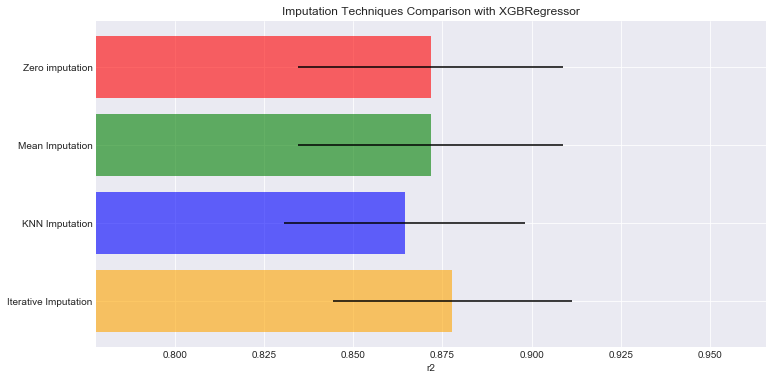

In [480]:
ax1.figure

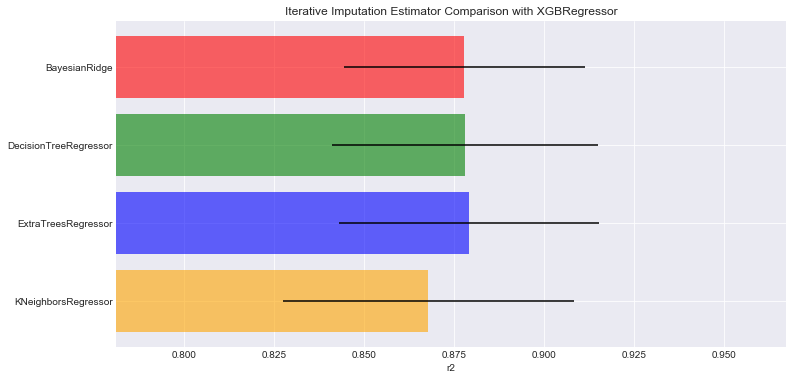

In [481]:
ax2.figure

In [485]:
# We can see that the XGBRegressor has not surpassed the performance of the Gradient Boosting
# Regressor for this task. Let's try the XGBRFRegressor

#### XGBRFRegressor

In [486]:
regressor = XGBRFRegressor(objective='reg:squarederror')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

Imputing with IterativeImputer using BayesianRidge estimator


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-package

Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-package

Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-package

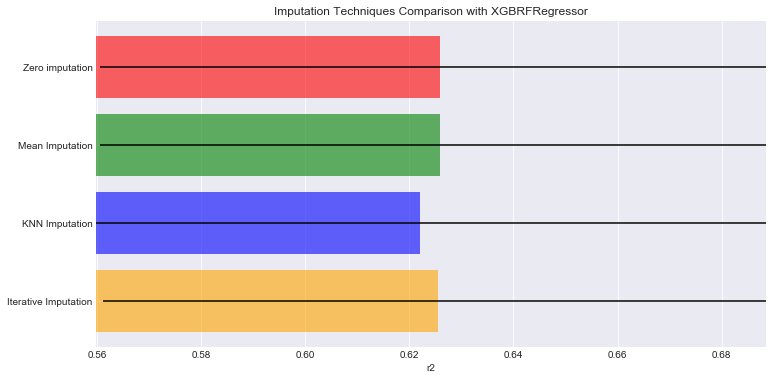

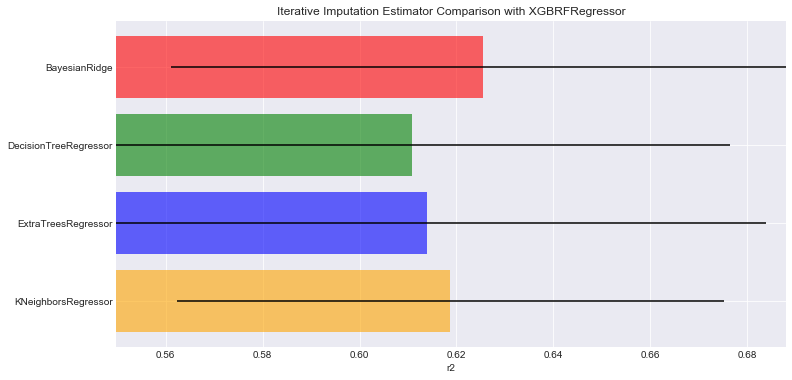

In [487]:
ax1, ax2 = compare_imputer_scores(X_new, 
                                  y, 
                                  regressor, 
                                  scoring='r2',
                                  iterative_estimators=estimators
                                 )

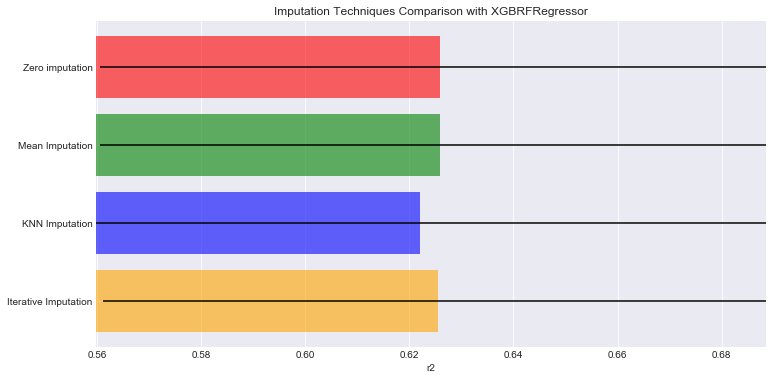

In [488]:
ax1.figure

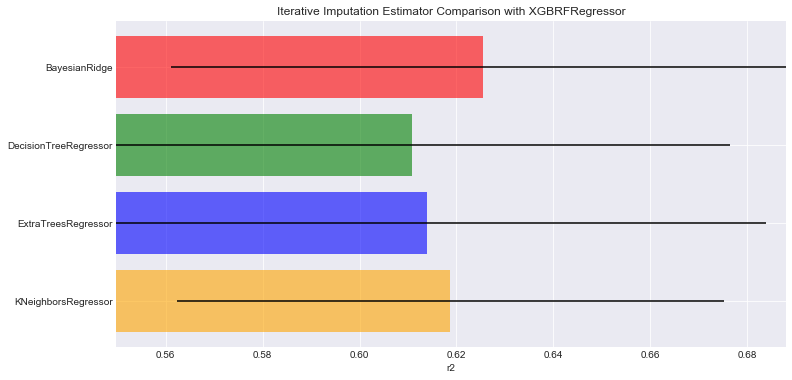

In [489]:
ax2.figure

In [ ]:
# The XGBRFRegressor has performed relatively poorly with huge variance in r2 scores

## Modeling the data
Now that we have evaluated methods of imputing missing data, it is time to model the prices using our features.

In [341]:
# Let's do some grid searching to tune the hyperparameters of the model
from sklearn.model_selection import GridSearchCV

In [342]:
from sklearn.pipeline import Pipeline

In [344]:
imputer_estimator = BayesianRidge()
#n_nearest_features = None
sample_posterior = True

scaler = StandardScaler()

imputer = IterativeImputer(estimator=imputer_estimator,
                           missing_values=np.nan, 
                           add_indicator=True,
                           random_state=123,
                           sample_posterior=sample_posterior
                          )

regressor = GradientBoostingRegressor(loss='huber', random_state=0)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('regressor', regressor)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'imputer__n_nearest_features': [5, 10, 20, None],
              #'regressor__loss': ['ls', 'lad', 'huber'],
              'regressor__learning_rate': [.001, .01, .1, .5],
              'regressor__n_estimators': [100, 200, 300, 500],
              'regressor__subsample': [0.5, 0.7, 1.0],
              'regressor__max_depth': [2, 3, 5, 7]
             }

grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring='r2', cv=5)
grid_fit = grid_search.fit(X_new, y)

In [345]:
grid_fit.best_params_

{'imputer__n_nearest_features': 20,
 'regressor__learning_rate': 0.1,
 'regressor__max_depth': 2,
 'regressor__n_estimators': 500,
 'regressor__subsample': 0.7}

In [346]:
grid_fit.best_score_

0.9076299097923837

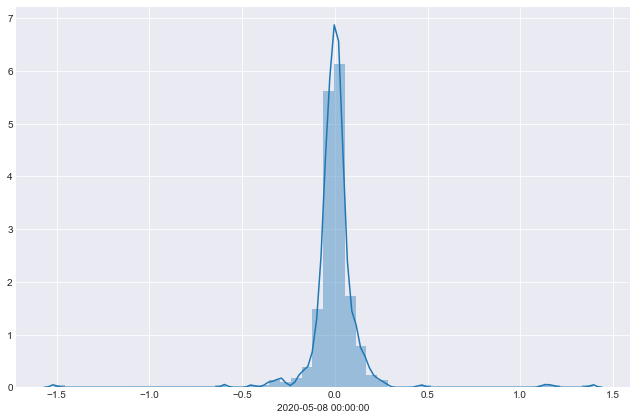

In [347]:
# This looks good, after a long time we have our optimal parameters and a good r2 of .90
# The whole idea in generating this model was to use the residuals from it to see if they have
# a relationship with the actual returns, hopefully a nice linear relationship, let's generate
# residuals and have a look
preds = grid_fit.best_estimator_.predict(X_new)
resids = y - preds
sns.distplot(resids)

In [348]:
# We can see a nice tight, symmetrical distribution of residuals

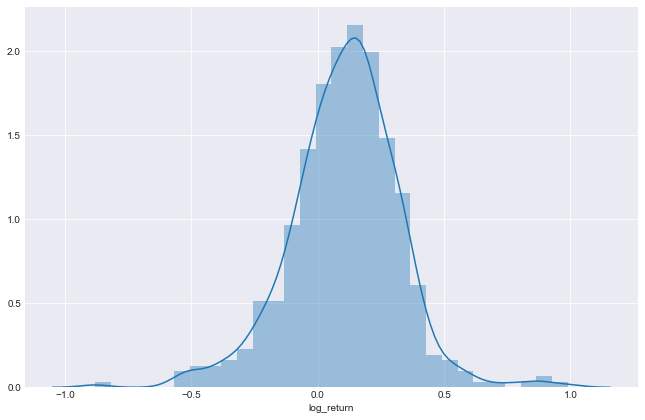

In [349]:
# Let's look again at our log returns over the period of study
sns.distplot(log_returns.log_return)

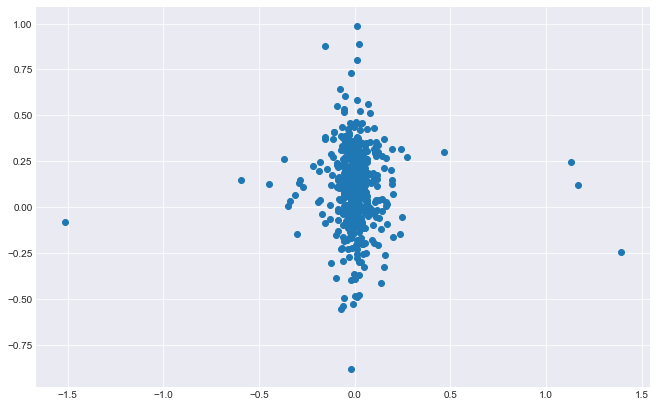

In [350]:
# Let's plot them together and see if there is a visual relationship
plt.scatter(resids, log_returns.log_return)

In [351]:
# We would have been hoping to see a negative linear relationship here, since higher residual
# values would correspond possibly to overvalued securities, as their current trading price
# would have been higher than what the model figured. The range of the residuals is very narrow,
# so right now I'm not seeing the kind of relation I was hoping for. Let's run a linreg anyways
# and see what we get
test_df = pd.DataFrame(zip(resids, log_returns.log_return))
test_df.columns = ['resids', 'log_returns']
test_df.head()

,resids,log_returns
0,-0.007954,0.250673
1,-0.035211,0.095848
2,0.027050,0.161577
3,-0.035499,0.398815
4,-0.054987,-0.014316


Linear Regression for log_returns~resids


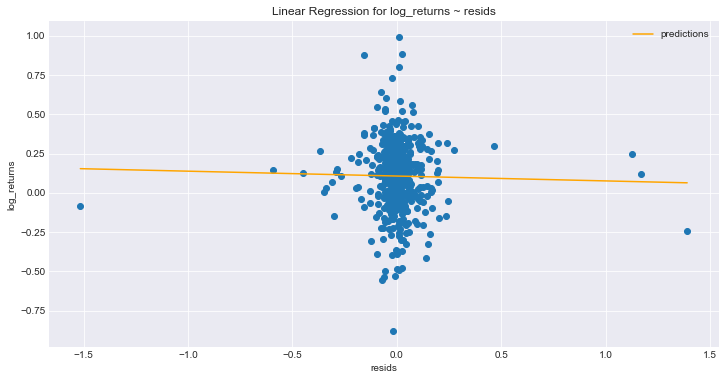

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2208
Date:                Tue, 03 Nov 2020   Prob (F-statistic):              0.639
Time:                        18:12:40   Log-Likelihood:                 57.078
No. Observations:                 499   AIC:                            -110.2
Df Residuals:                     497   BIC:                            -101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1066      0.010     11.005      0.000       0.088       0.126
resids        -0.0310      0.066     -0.470      0.639      -0.161       0.099
==============================================================================
Omnibus:                       29.738   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.568
Skew:                          -0.178   Prob(JB):                     5.86e-20
Kurtosis:                       5.033   Cond. No.                         6.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,0.768781,0.0501257


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.347984e-01 
 9.752842e-01 
 
 
 p-value 
 2.251110e-50 
 1.824088e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 2.370295 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 8.856762e+01 
 
 
 p-value 
 5.858478e-20 
 
 
 Skew 
 -1.784606e-01 
 
 
 Kurtosis 
 5.032824e+00

Skew: -0.17846056337574667
Kurtosis: 2.0328238491570216


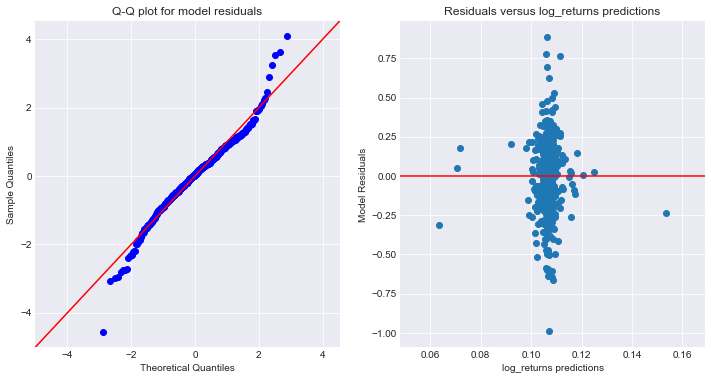

In [352]:
mf.do_a_linreg(test_df, ['resids'], 'log_returns')

The results of this investigation have been interesting. The hypothesis was that if a model could be developed to regress the current trading price of a security with accuracy, then deviations of individual prices from model predictions expressed in the residuals may indicate current overvaluing or undervaluing in the market which could then be used as signals for future price movement. While a great model for regressing trading price was developed using Decision Tree Imputation and a Gradient Boosting Classifier, the relationship between the model residuals and price movements over the time period studied was not found. Future work may determine a more tangible use for modeling current trading price with fundamental data, or perhaps a different/longer time period of consideration may show a relationship between returns and residuals from such a model, but in this instance the research is inconclusive, and it will be necessary to find other ways to utilize the database for business purposes.

In [118]:
# A quick check to make sure our indexes were consistent
print("Number of discrepancies between indexes")
sum(X_new.index == log_returns.index) - len(X_new)

Number of discrepancies between indexes


0

In [119]:
# Thankfully, no error was made with inconsistent indexes. The hypothesis has failed to be
# proven, though a nice model was achieved for regressing price. I'd like to try another way

I have just realized a major issue with the predictors. Both Market Cap and Float are in the features, which together relate to the price of a security. Float is the number of shares available for trading, and Market Cap is the total number of shares multiplied by the price of a stock. This may have contributed to the high r-squared we were getting, as the regressor may have found this relationship. We need to try the whole thing again without having Market Cap present in the data.

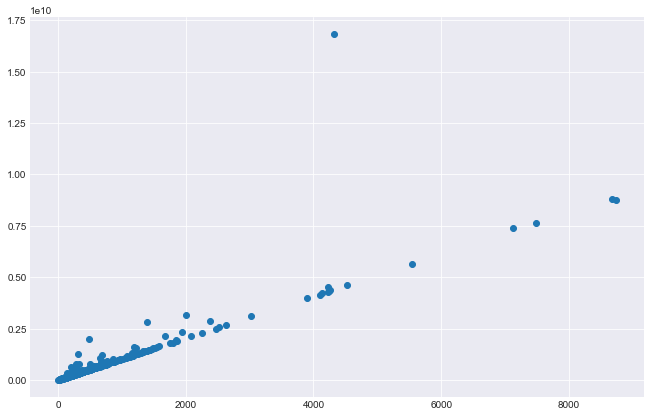

In [120]:
# For fun, let's divide the market cap by price, and plot with Float
float_calc = X_new.marketCap / sp500_close.iloc[0].T.loc[X_new.index]
plt.scatter(X_new.Float, float_calc)

In [121]:
# We can see that this relationship is not perfect but is highly linear along the 1 line
# We need to now drop Market Cap, and repeat the process of creating a model (bummer)
X_new = X_new.drop('marketCap', axis=1)
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 52 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
Annual Dividend %                                    392 non-null float64
Beta                                                 486 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Days to Cover                                        493 non-null float64
Dividend Change %                                    403 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      488 non-null float64
EPS Growth (MRQ)                                     485 non-null float64
EPS Growth (TTM)                                     487 non-null float64
EPS Growth 5

In [129]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=0),
    KNeighborsRegressor(n_neighbors=30)
]

In [130]:
regressor = GradientBoostingRegressor(loss='huber', random_state=0)

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using ExtraTreesRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Imputing with IterativeImputer using KNeighborsRegressor estimator


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


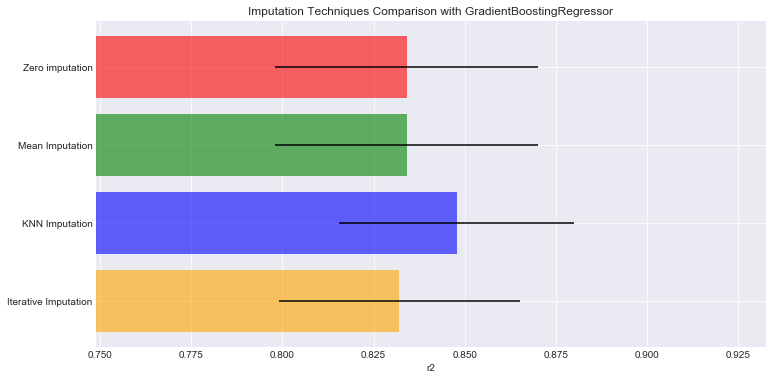

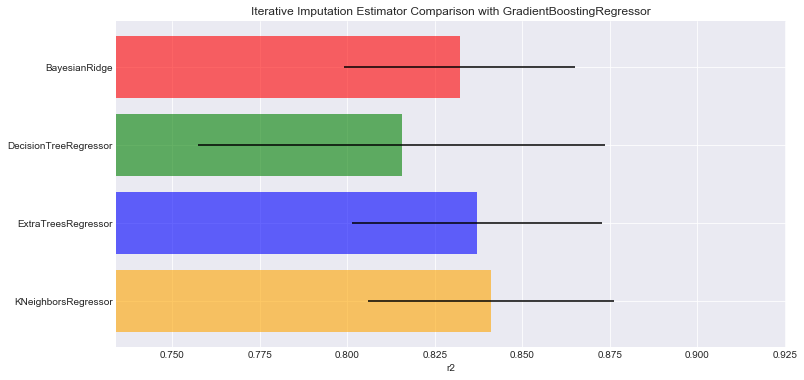

In [131]:
ax1, ax2 = compare_imputer_scores(X_new, 
                                  y, 
                                  regressor, 
                                  scoring='r2',
                                  iterative_estimators=estimators
                                 )

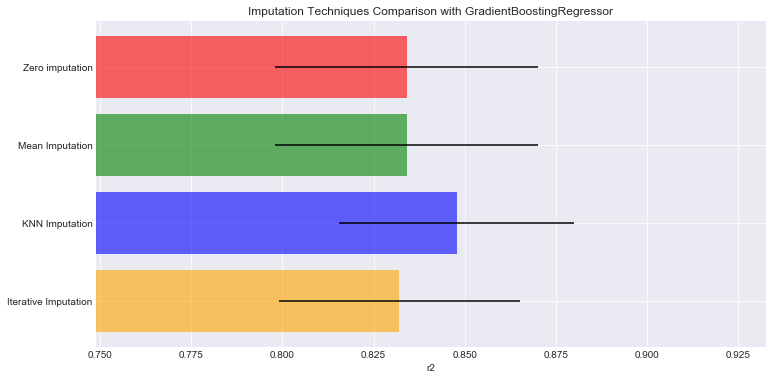

In [132]:
ax1.figure

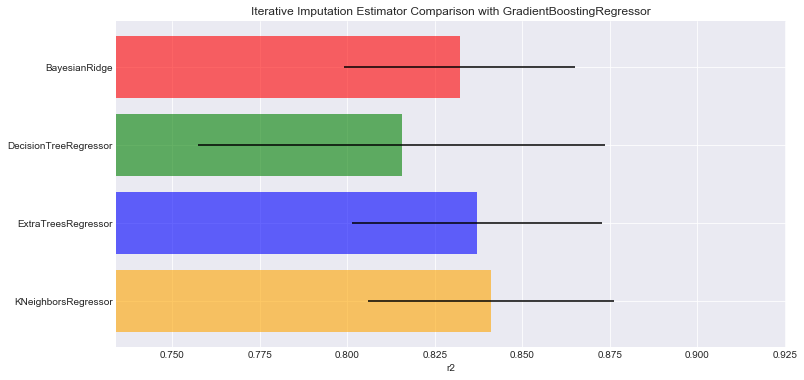

In [133]:
ax2.figure

In [362]:
# We can see these scores have dropped considerably from before we cut marketCap from the
# features, which is a good thing. We were cheating before.

In [ ]:
# It looks as though the KNN Imputer may be the best choice this time around. Let's build a
# pipeline and train a model.

In [379]:
scaler = StandardScaler()

imputer = KNNImputer(weights='distance', add_indicator=True)

regressor = GradientBoostingRegressor(loss='huber', random_state=0)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('regressor', regressor)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'imputer__n_neighbors': [5, 10, 20, 30],
              #'regressor__loss': ['ls', 'lad', 'huber'],
              'regressor__learning_rate': [.01, .1, .5],
              'regressor__n_estimators': [300, 500, 1000],
              'regressor__subsample': [0.7, 0.8, 1.0],
              'regressor__max_depth': [2, 3, 5]
             }

grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring='r2', cv=5)
grid_fit = grid_search.fit(X_new, y)

In [380]:
grid_fit.best_params_

{'imputer__n_neighbors': 5,
 'regressor__learning_rate': 0.1,
 'regressor__max_depth': 2,
 'regressor__n_estimators': 1000,
 'regressor__subsample': 0.7}

In [381]:
grid_fit.best_score_

0.8715783910502225

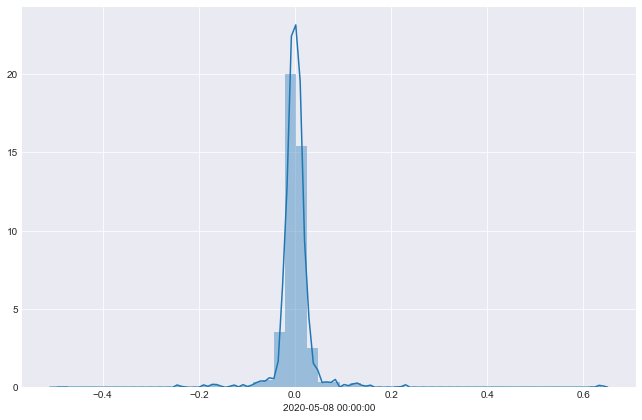

In [382]:
# This looks good, after a long time we have our optimal parameters and a good r2 of .87
# The whole idea in generating this model was to use the residuals from it to see if they have
# a relationship with the actual returns, hopefully a nice linear relationship, let's generate
# residuals and have a look
preds = grid_fit.best_estimator_.predict(X_new)
resids = y - preds
sns.distplot(resids)

In [383]:
# We can see a nice tight, symmetrical distribution of residuals

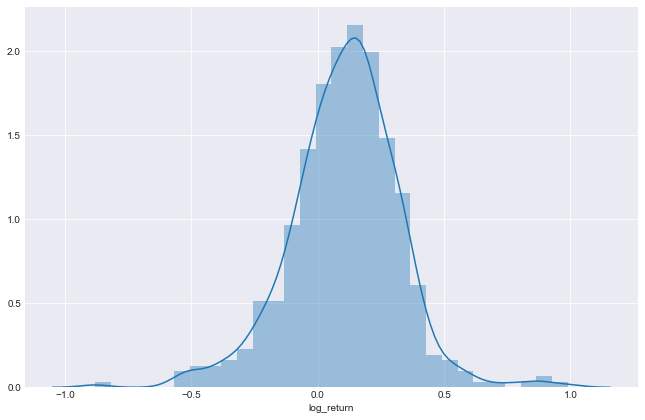

In [384]:
# Let's look again at our log returns over the period of study
sns.distplot(log_returns.log_return)

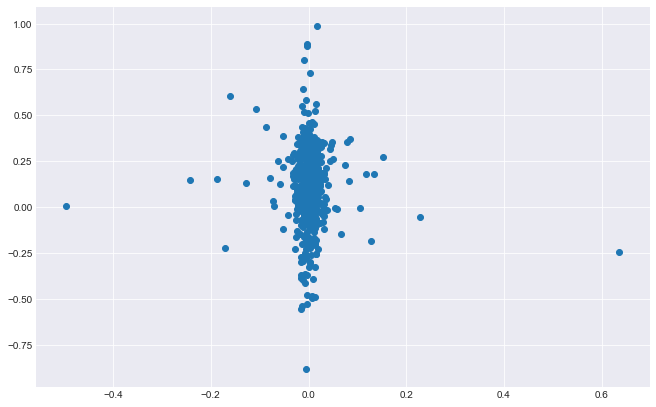

In [385]:
# Let's plot them together and see if there is a visual relationship
plt.scatter(resids, log_returns.log_return)

In [386]:
# We would have been hoping to see a negative linear relationship here, since higher residual
# values would correspond possibly to overvalued securities, as their current trading price
# would have been higher than what the model figured. The range of the residuals is very narrow,
# so right now I'm not seeing the kind of relation I was hoping for. Let's run a linreg anyways
# and see what we get
test_df = pd.DataFrame(zip(resids, log_returns.log_return))
test_df.columns = ['resids', 'log_returns']
test_df.head()

,resids,log_returns
0,-0.063232,0.250673
1,-0.020330,0.095848
2,0.010000,0.161577
3,0.001415,0.398815
4,-0.004952,-0.014316


Linear Regression for log_returns~resids


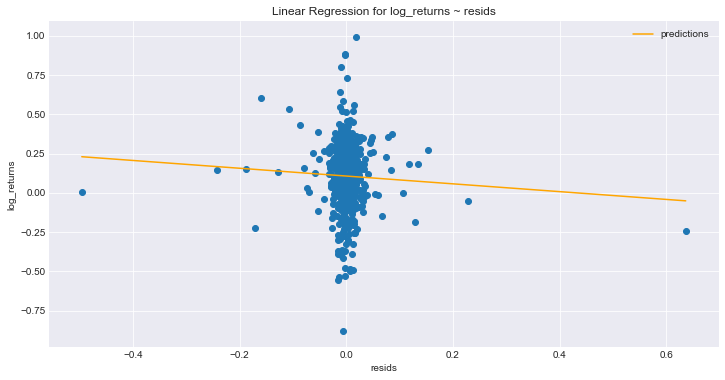

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.516
Date:                Tue, 03 Nov 2020   Prob (F-statistic):              0.219
Time:                        20:50:54   Log-Likelihood:                 57.727
No. Observations:                 499   AIC:                            -111.5
Df Residuals:                     497   BIC:                            -103.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1065      0.010     11.019      0.000       0.088       0.126
resids        -0.2481      0.202     -1.231      0.219      -0.644       0.148
==============================================================================
Omnibus:                       30.229   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.817
Skew:                          -0.183   Prob(JB):                     1.90e-20
Kurtosis:                       5.058   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,0.769046,0.0504271


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.365026e-01 
 9.750816e-01 
 
 
 p-value 
 6.743933e-51 
 1.644556e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 2.32996 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 9.081662e+01 
 
 
 p-value 
 1.902924e-20 
 
 
 Skew 
 -1.827116e-01 
 
 
 Kurtosis 
 5.057766e+00

Skew: -0.18271164146159305
Kurtosis: 2.057765646345996


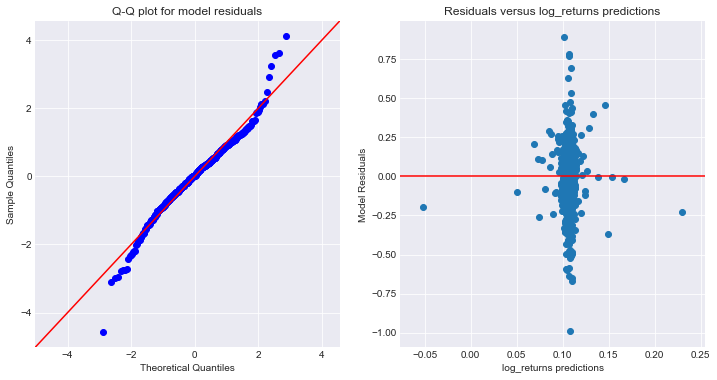

In [387]:
mf.do_a_linreg(test_df, ['resids'], 'log_returns')

Linear Regression for log_returns~resids


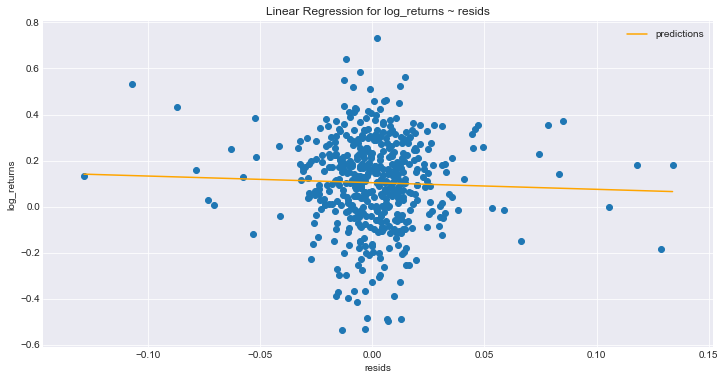

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5804
Date:                Tue, 03 Nov 2020   Prob (F-statistic):              0.447
Time:                        21:43:57   Log-Likelihood:                 100.02
No. Observations:                 485   AIC:                            -196.0
Df Residuals:                     483   BIC:                            -187.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1040      0.009     11.608      0.000       0.086       0.122
resids        -0.2879      0.378     -0.762      0.447      -1.030       0.455
==============================================================================
Omnibus:                       18.464   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.157
Skew:                          -0.407   Prob(JB):                     2.55e-05
Kurtosis:                       3.620   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,0.55134,1.39451e-05


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.448875e-01 
 0.987026 
 
 
 p-value 
 4.981573e-52 
 0.000259 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 1.416065 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 21.156964 
 
 
 p-value 
 0.000025 
 
 
 Skew 
 -0.406834 
 
 
 Kurtosis 
 3.620392

Skew: -0.40683429430259765
Kurtosis: 0.6203918013462424


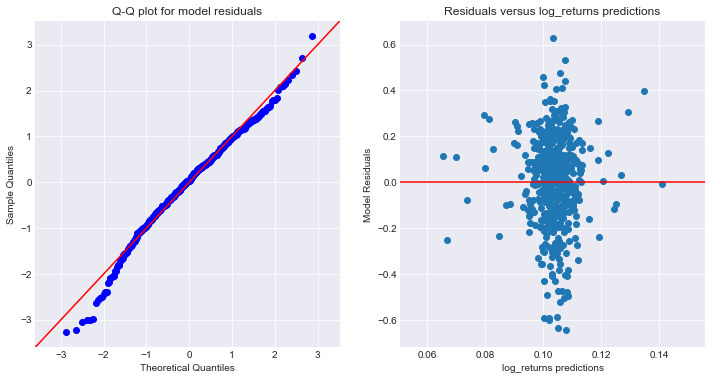

In [394]:
# Let's see how this is affected if we remove outliers
from scipy import stats
df_trim = test_df[(np.abs(stats.zscore(test_df)) < 3).all(axis=1)]

mf.do_a_linreg(df_trim, ['resids'], 'log_returns')

## Trying things another way
The richness in features of the scraped dataset is nice, but the last model we made was trained using a lot of features, some of which were not necessarily related to the fundamentals of the companies. The model performed very well with cross-validation, with an r-squared of .87, but it is possible that using a more limited feature set and sacrificing model accuracy may actually help reveal fundamental under/over pricing in the market. The goal was to find a new way to calculate intrinsic value of the securities, based on fundamental data, so using this large amount of features may have made the model great at predicting market price, but not necessarily at modeling the fundamental intrinsic value of the securities, which really is a hidden target. Markets track value very well, so using the market prices as a target to train the model is sensible, but using more than just the fundamental information about a company may be compromising the value of the information represented in the residuals, since model accuracy is measuring ability to predict market price, but what we are trying to model is actually the hidden intrinsic price. 

To test this hypothesis, we can trim the featureset down to only fundamental features, and also try to employ some dimensionality reduction in the form of PCA to see the results.

In [ ]:
# First, let's see what the feature importances look like for our last model.

In [395]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 52 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
Annual Dividend %                                    392 non-null float64
Beta                                                 486 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Days to Cover                                        493 non-null float64
Dividend Change %                                    403 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      488 non-null float64
EPS Growth (MRQ)                                     485 non-null float64
EPS Growth (TTM)                                     487 non-null float64
EPS Growth 5

In [424]:
est = Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(add_indicator=False, weights='distance')),
                ('regressor',
                 GradientBoostingRegressor(loss='huber', max_depth=2,
                                           n_estimators=1000, random_state=0,
                                           subsample=0.7))])

In [426]:
cv_scores = cross_val_score(est, X_new, y, scoring='r2', cv=5)
cv_scores.mean()

0.867723137804532

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42)
est.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 GradientBoostingRegressor(loss='huber', max_depth=2,
                                           n_estimators=1000, random_state=0,
                                           subsample=0.7))])

In [428]:
feature_importance = est.steps[2][1].feature_importances_

Text(0.5, 1.0, 'Feature Importance (MDI)')

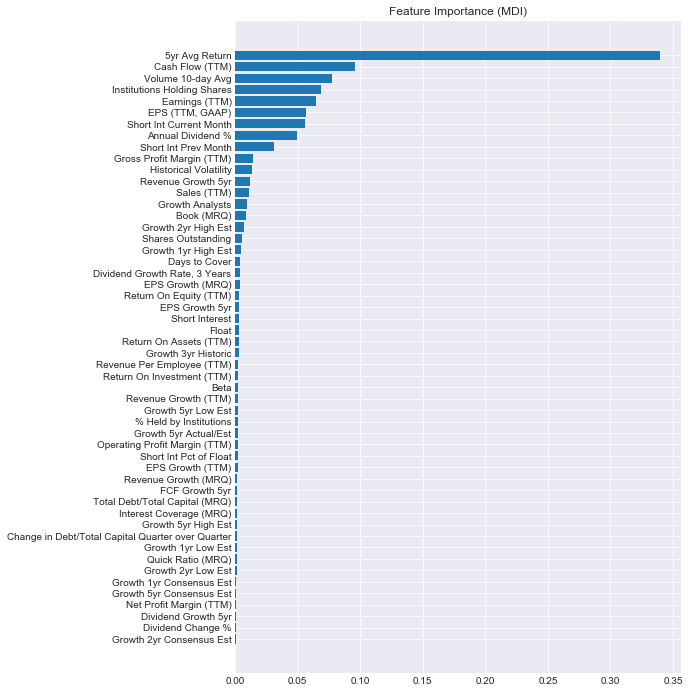

In [429]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 12))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_new.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

In [ ]:
# We can see here that 5yr average return was far and away the most important feature,
# with Cash Flow, Volume, Institutions Holding Shares, Earnings, Dividend, and Short Interest
# related features following. These importances may be a bit hard to interepret because some
# of these features are highly correlated with each other.

In [430]:
from sklearn.inspection import permutation_importance

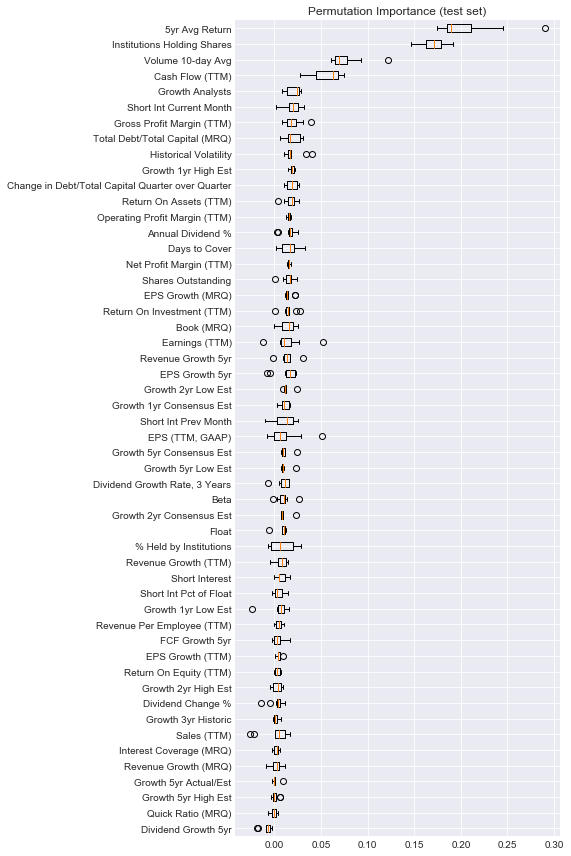

In [431]:
result = permutation_importance(est, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,12))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_new.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
# Again, we see 5yr Avg Return at the top of the list, but some of the other features may be
# having their actual importance watered down by the fact that they have correlated features
# present in the feature set.

In [432]:
# First, I'd like to simply add some PCA for dimensionality reduction, and see what kind of an
# impact on the residuals this could have. In this case, a bit less accuracy in the model might
# be helpful in spreading out the residuals, but it doesn't mean that a correlation to returns
# will appear.
from sklearn.decomposition import PCA

In [433]:
scaler = StandardScaler()
imputer = KNNImputer(weights='distance')
X_scaled = scaler.fit_transform(X_new)
X_imputed = imputer.fit_transform(X_scaled)
pca = PCA(n_components=len(X_new.columns), whiten=True)
X_pca = pca.fit_transform(X_imputed)

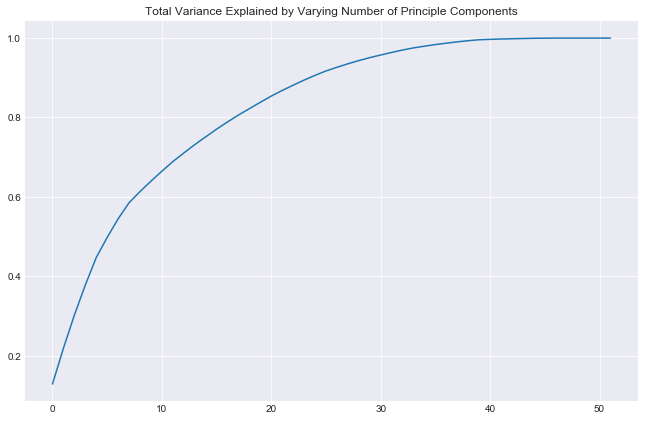

In [434]:
plt.plot(range(len(X_new.columns)), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principle Components');

In [436]:
from sklearn.metrics import r2_score

In [439]:
steps = [('scaler', StandardScaler()),
         ('imputer', KNNImputer()),
         ('pca', PCA(10)),
         ('regressor', GradientBoostingRegressor())
        ]

est = Pipeline(steps=steps)
est.fit(X_train, y_train)
preds = est.predict(X_test)
print("R2 Score:", r2_score(y_test, preds))

R2 Score: 0.7437335675980772


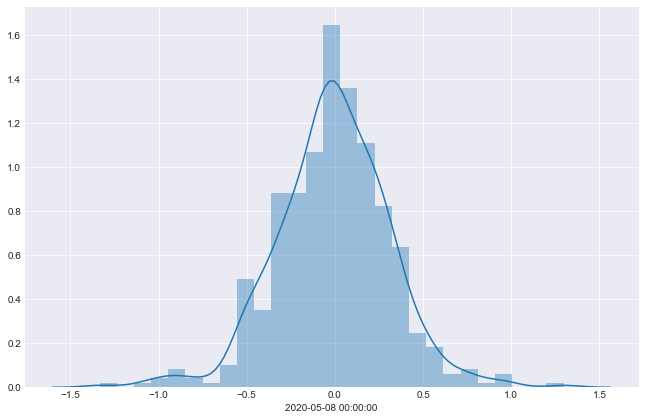

In [440]:
preds = est.predict(X_new)
resids = y - preds
sns.distplot(resids)

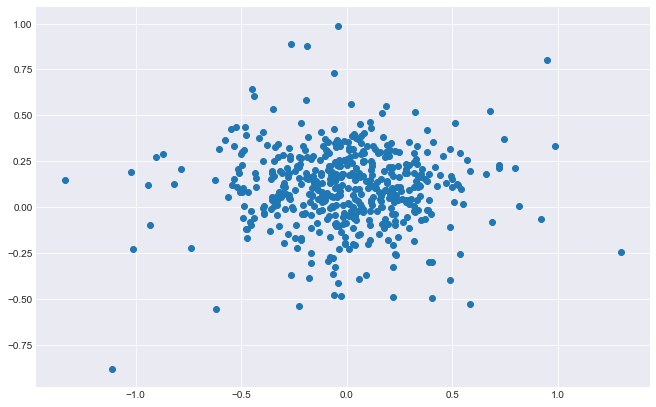

In [441]:
plt.scatter(resids, log_returns.log_return)

Linear Regression for log_return~resids


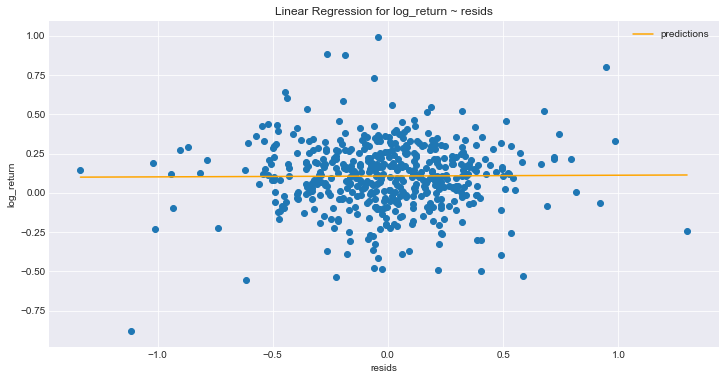

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.02987
Date:                Tue, 03 Nov 2020   Prob (F-statistic):              0.863
Time:                        23:14:31   Log-Likelihood:                 56.982
No. Observations:                 499   AIC:                            -110.0
Df Residuals:                     497   BIC:                            -101.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1065      0.010     10.997      0.000       0.087       0.126
resids         0.0052      0.030      0.173      0.863      -0.054       0.065
==============================================================================
Omnibus:                       29.443   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.346
Skew:                          -0.175   Prob(JB):                     1.08e-19
Kurtosis:                       5.020   Cond. No.                         3.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,0.768948,0.0503151


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.339817e-01 
 9.752457e-01 
 
 
 p-value 
 4.001398e-50 
 1.788426e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 2.410807 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 8.734630e+01 
 
 
 p-value 
 1.078927e-19 
 
 
 Skew 
 -1.750462e-01 
 
 
 Kurtosis 
 5.019520e+00

Skew: -0.17504623361348673
Kurtosis: 2.0195196786731735


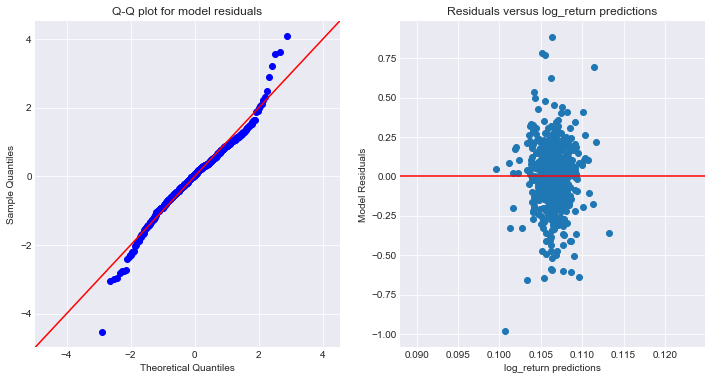

In [444]:
# We do not see a linear relationship here
test_df = pd.DataFrame(zip(resids, log_returns.log_return), columns=['resids', 
                                                                                   'log_return'
                                                                                  ])
mf.do_a_linreg(test_df, ['resids'], 'log_return')

### Using ONLY fundamental features to model price

In [445]:
# No linear relationsip is present between the residuals of this pricing model and the returns
# since May 8th. Applying PCA has not helped.
# The last thing to try and do is build a model with very restricted fundamental inputs, and
# see if this has any benefit.
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 52 columns):
% Held by Institutions                               493 non-null float64
5yr Avg Return                                       499 non-null float64
Annual Dividend %                                    392 non-null float64
Beta                                                 486 non-null float64
Change in Debt/Total Capital Quarter over Quarter    471 non-null float64
Days to Cover                                        493 non-null float64
Dividend Change %                                    403 non-null float64
Dividend Growth 5yr                                  354 non-null float64
Dividend Growth Rate, 3 Years                        392 non-null float64
EPS (TTM, GAAP)                                      488 non-null float64
EPS Growth (MRQ)                                     485 non-null float64
EPS Growth (TTM)                                     487 non-null float64
EPS Growth 5

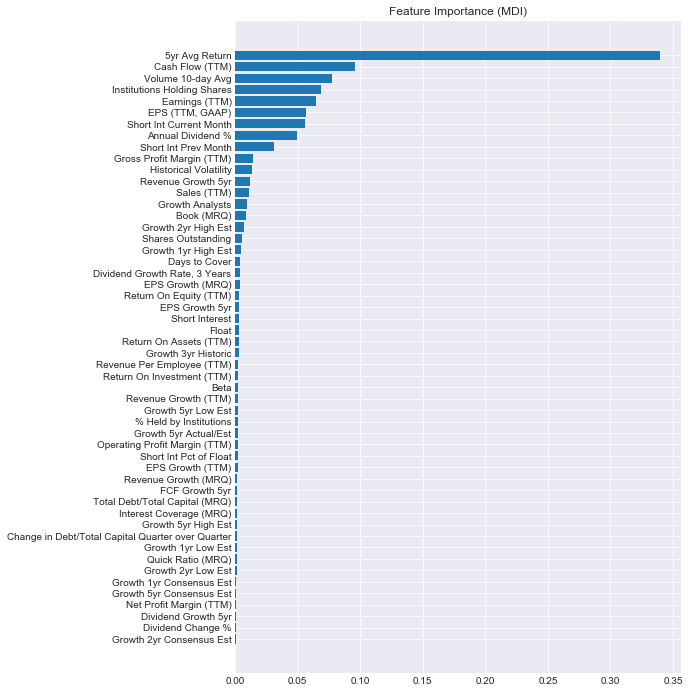

In [447]:
# 5yr Avg Return is very predictive, which makes sense because after 5 solid years of good
# returns, you would expect a price would be pretty high. I will leave this feature out, to
# try and focus on fundamentals.
# I will also leave out Volume and Historical Volatility, which have more to do with price than
# fundamentals.
fundamental_features = ['Cash Flow (TTM)',
                        'Earnings (TTM)',
                        'EPS (TTM, GAAP)',
                        'Gross Profit Margin (TTM)',
                        'Revenue Growth 5yr',
                        'Sales (TTM)',
                        'Book (MRQ)',
                        'EPS Growth (MRQ)',
                        'Return On Equity (TTM)',
                        'EPS Growth 5yr',
                        'Return On Assets (TTM)',
                        'Revenue Per Employee (TTM)',
                        'Return On Investment (TTM)',
                        'Beta',
                        'Revenue Growth (TTM)',
                        'Operating Profit Margin (TTM)',
                        'EPS Growth (TTM)',
                        'Revenue Growth (MRQ)',
                        'FCF Growth 5yr',
                        'Total Debt/Total Capital (MRQ)',
                        'Interest Coverage (MRQ)',
                        'Change in Debt/Total Capital Quarter over Quarter',
                        'Quick Ratio (MRQ)',
                        'Net Profit Margin (TTM)'
                       ]

X_fundies = X_new[fundamental_features].copy()

In [449]:
scaler = StandardScaler()

imputer = KNNImputer(weights='distance', add_indicator=False)

regressor = GradientBoostingRegressor(loss='huber', random_state=0)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('regressor', regressor)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'imputer__n_neighbors': [5, 10, 20],
              #'regressor__loss': ['ls', 'lad', 'huber'],
              'regressor__learning_rate': [.01, .1, .5],
              'regressor__n_estimators': [500, 1000],
              'regressor__subsample': [0.7, 1.0],
              'regressor__max_depth': [2, 3, 5]
             }

grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring='r2', cv=5)
grid_fit = grid_search.fit(X_fundies, y)

In [450]:
grid_fit.best_params_

{'imputer__n_neighbors': 5,
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 5,
 'regressor__n_estimators': 1000,
 'regressor__subsample': 0.7}

In [451]:
grid_fit.best_score_

0.6794544449000117

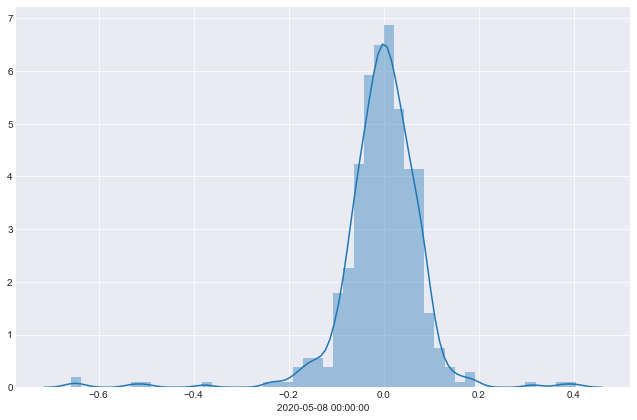

In [453]:
# This looks good, after a long time we have our optimal parameters and a good r2 of .90
# The whole idea in generating this model was to use the residuals from it to see if they have
# a relationship with the actual returns, hopefully a nice linear relationship, let's generate
# residuals and have a look
preds = grid_fit.best_estimator_.predict(X_fundies)
resids = y - preds
sns.distplot(resids)

In [454]:
# We can see a nice tight, symmetrical distribution of residuals

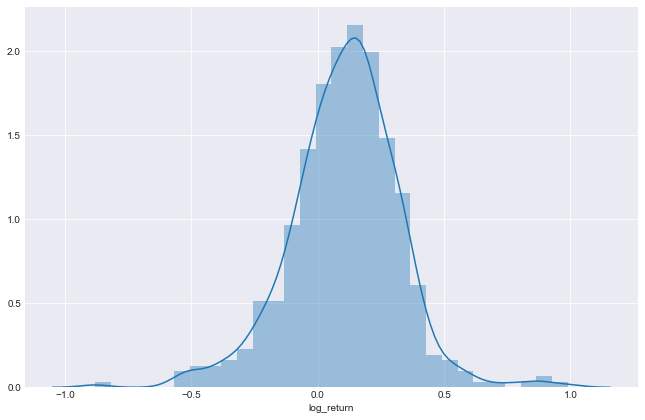

In [455]:
# Let's look again at our log returns over the period of study
sns.distplot(log_returns.log_return)

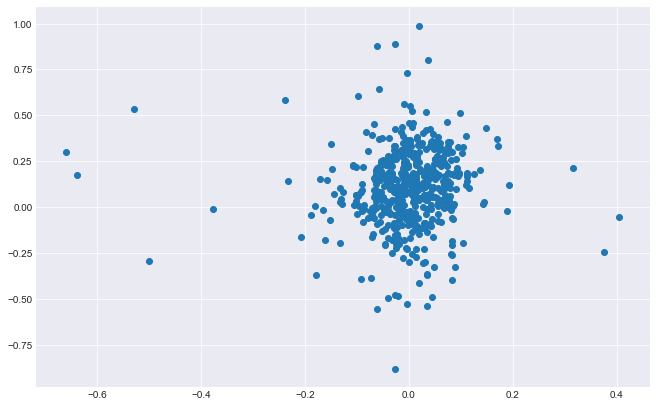

In [456]:
# Let's plot them together and see if there is a visual relationship
plt.scatter(resids, log_returns.log_return)

In [457]:
# There does not seem to be a linear relationship between residuals and returns developing here,
# even using only fundamental features. A longer time period than 6 months may have different
# results, but so far our hypothesis is not supported. Let's run a linreg.
test_df = pd.DataFrame(zip(resids, log_returns.log_return))
test_df.columns = ['resids', 'log_returns']
test_df.head()

,resids,log_returns
0,-0.054049,0.250673
1,-0.035543,0.095848
2,0.053406,0.161577
3,0.045790,0.398815
4,-0.164961,-0.014316


Linear Regression for log_returns~resids


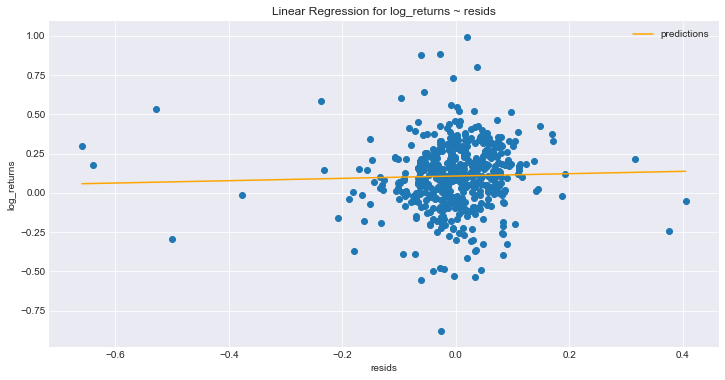

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4599
Date:                Wed, 04 Nov 2020   Prob (F-statistic):              0.498
Time:                        00:08:01   Log-Likelihood:                 57.198
No. Observations:                 499   AIC:                            -110.4
Df Residuals:                     497   BIC:                            -102.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1067      0.010     11.019      0.000       0.088       0.126
resids         0.0744      0.110      0.678      0.498      -0.141       0.290
==============================================================================
Omnibus:                       29.810   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.189
Skew:                          -0.170   Prob(JB):                     2.60e-20
Kurtosis:                       5.055   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,0.765916,0.046964


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.347954e-01 
 9.746253e-01 
 
 
 p-value 
 2.255912e-50 
 1.304526e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 2.501837 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 9.018858e+01 
 
 
 p-value 
 2.604951e-20 
 
 
 Skew 
 -1.698574e-01 
 
 
 Kurtosis 
 5.054829e+00

Skew: -0.1698573948542619
Kurtosis: 2.0548286906849658


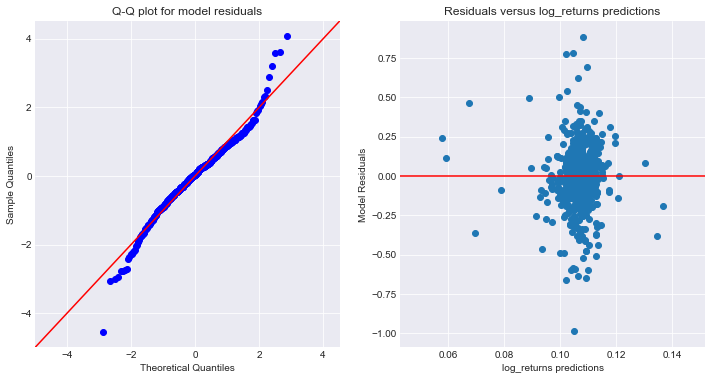

In [458]:
mf.do_a_linreg(test_df, ['resids'], 'log_returns')

Linear Regression for log_returns~resids


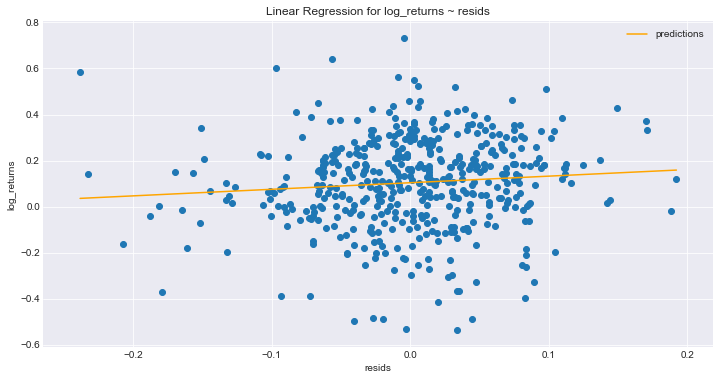

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.141
Date:                Wed, 04 Nov 2020   Prob (F-statistic):             0.0424
Time:                        00:08:14   Log-Likelihood:                 101.96
No. Observations:                 485   AIC:                            -199.9
Df Residuals:                     483   BIC:                            -191.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1039      0.009     11.647      0.000       0.086       0.121
resids         0.2854      0.140      2.035      0.042       0.010       0.561
==============================================================================
Omnibus:                       18.995   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.564
Skew:                          -0.381   Prob(JB):                     7.64e-06
Kurtosis:                       3.764   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test for homoscedasticity of residuals:


,F_statistic,p_value
Goldfeld-Quandt,0.574676,5.20848e-05


Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 3.425563e-01 
 0.985712 
 
 
 p-value 
 2.582822e-51 
 0.000107 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 1.657885 
 0.781 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 23.564347 
 
 
 p-value 
 0.000008 
 
 
 Skew 
 -0.381486 
 
 
 Kurtosis 
 3.764164

Skew: -0.3814855371364886
Kurtosis: 0.7641635565284317


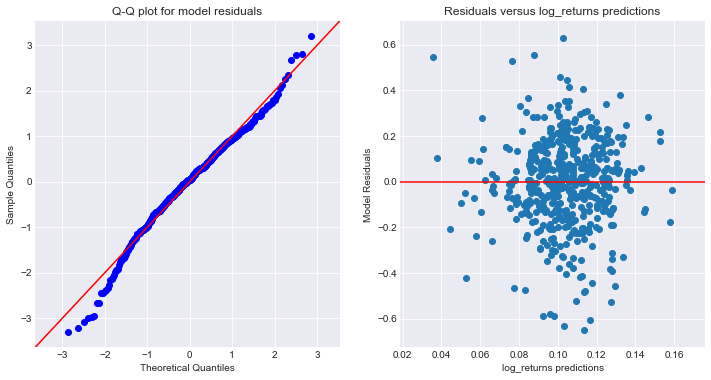

In [459]:
# Let's see how this is affected if we remove outliers
from scipy import stats
df_trim = test_df[(np.abs(stats.zscore(test_df)) < 3).all(axis=1)]

mf.do_a_linreg(df_trim, ['resids'], 'log_returns')

In [ ]:
# For the first time, our coefficient for residuals is significant with an alpha = 0.05. The
# problem is that the relationship is positive, so that securities which were overvalued
# compared to the model estimates actually performed better over the 6 months since the study.
# This is actually not that surprising, as a 6 month holding period is really not that long in
# the world of investment, and hot stocks which have momentum tend to continue their momentum
# as momentum itself is a feature that attracts short term investors, and causes stocks to become
# over-valued due to the influx of traders expecting short-term gains. As stated above, this
# test might work better with a long time period of a year or possibly several.

## Conclusions
After trying this multiple ways, I am concluding that the residuals from models trained to regress the current trading price of stocks using fundamental data as exogenous features are not showing a significant relationship with returns since the date of the scrape. As mentioned before, the idea behind value investing is to calculate the intrinsic, hidden value of a stock, and then expect the market to move toward it. These models have done a good job modeling the current trading price using the fundamental features, but since the trading price, and not the intrinsic value, was the target variable, we cannot be sure that such models are reflective of anything other than the current trading price. Further, value investors typically expect to invest over long time horizons, often over a year, so the shorter time period observed in this study may not be long enough for the markets to adjust toward intrinsic value in the way that value investors intend, and the returns over this period may be more noise than they are purposeful movements, or may be the result of shorter-term momentum trades.